We are given 6 pieces of training data and two pieces of validation data. The goal is to perform registration based segmentation of MRI scans to maximize either jaccard overlap or dice coefficients. The ROIs that we care about are the cerebral cortex and the cerebral white matter.

<bR>
 As stated below, the methods that work are closer to the bottom of this notebook.
<br>

__Notes:__
Make sure that the file 'MS1Data.npy' is in the directory before running the jupyter notebook. This jupyter notebook is organized as follows:
<br>
- Libraries Used
- Transformations
- Loss Functions
- Optimization Functions
- Segmentation Functions
- Jaccard Overlap Functions
- Pre-processing Functions
- Attempted Methods

<br>
The different methods tested section is organized roughly by least successful to most successful. Some of the methods have a very long run time (A warning will appear in the descriptions if this is the case)

<b>Libraries that we use</b>

In [2]:
import os
import numpy as np #for general math
import scipy as sp #for statistical analysis and optimization
import nibabel as nib #for handling the given MRI format
from nibabel.testing import data_path
import imageio #for saving images to files
import matplotlib.pyplot as plt #for displaying images
from PIL import Image #for image processing and transformation functions
from scipy import optimize
import pandas as pd #for storing data
import skimage as ski #for image processing and transformation functions
import skimage.transform as tf
from skimage import filters
import cv2 #I was playing cv2's functions and filters
from skimage.filters.rank import mean_bilateral #for pre-processing
from skimage.filters.rank import enhance_contrast #for pre-processing
from skimage.filters.rank import enhance_contrast_percentile #for pre-processing
from skimage.morphology import disk #for pre-processing
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, #for pre-processing
                                 denoise_wavelet, estimate_sigma)
import SimpleITK as sitk #non-linear diffeomorphic image registration

#changing matplotlib image display format
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

<b>Our Data:</b>

In [3]:
#load the data from milestone 1
MS1Data = np.load('MS1Data.npy', allow_pickle=True)

'''
    - The images are min maxed normalized between 0 and 255
    - img->MRI scan
    - seg->Segmentation
'''

#Training Data

S1img = np.ndarray.astype(np.array([MS1Data[0][0]/np.max(MS1Data[0][0])*255]), np.int)
S1seg = MS1Data[1]
S2img = np.ndarray.astype(np.array([MS1Data[2][0]/np.max(MS1Data[2][0])*255]), np.int)
S2seg = MS1Data[3]
S3img = np.ndarray.astype(np.array([MS1Data[4][0]/np.max(MS1Data[4][0])*255]), np.int)
S3seg = MS1Data[5]
S4img = np.ndarray.astype(np.array([MS1Data[6][0]/np.max(MS1Data[6][0])*255]), np.int)
S4seg = MS1Data[7]
S5img = np.ndarray.astype(np.array([MS1Data[8][0]/np.max(MS1Data[8][0])*255]), np.int)
S5seg = MS1Data[9]
S6img = np.ndarray.astype(np.array([MS1Data[10][0]/np.max(MS1Data[10][0])*255]), np.int)
S6seg = MS1Data[11]

#Validation Data

S7img = np.ndarray.astype(np.array([MS1Data[12][0]/np.max(MS1Data[12][0])*255]), np.int)
S7seg = MS1Data[13]
S15img = np.ndarray.astype(np.array([MS1Data[14][0]/np.max(MS1Data[14][0])*255]), np.int)
S15seg = MS1Data[15]

# Load the volumetric Data Because we might use that for registration also

VolsT = np.load('VolumesTraining.npy', allow_pickle=True)

V1img = np.ndarray.astype(np.array([VolsT[0]/np.max(VolsT[0])*255]), np.int)[0]
V1seg = VolsT[1]
V2img = np.ndarray.astype(np.array([VolsT[2]/np.max(VolsT[2])*255]), np.int)[0]
V2seg = VolsT[3]
V3img = np.ndarray.astype(np.array([VolsT[4]/np.max(VolsT[4])*255]), np.int)[0]
V3seg = VolsT[5]
V4img = np.ndarray.astype(np.array([VolsT[6]/np.max(VolsT[6])*255]), np.int)[0]
V4seg = VolsT[7]
V5img = np.ndarray.astype(np.array([VolsT[8]/np.max(VolsT[8])*255]), np.int)[0]
V5seg = VolsT[9]
V6img = np.ndarray.astype(np.array([VolsT[10]/np.max(VolsT[10])*255]), np.int)[0]
V6seg = VolsT[11]
V7img = np.ndarray.astype(np.array([VolsT[12]/np.max(VolsT[12])*255]), np.int)[0]
V7seg = VolsT[13]
V15img = np.ndarray.astype(np.array([VolsT[14]/np.max(VolsT[14])*255]), np.int)[0]
V15seg = VolsT[15]

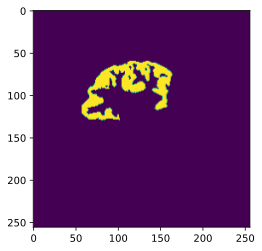

In [13]:
plt.imshow(V3seg[:, :, int(V3seg.shape[2]/2 - 1)]==42)

__Transformations:__

In [3]:
'''
General Affine Transformation function that uses PILLOW's affine transform.

    params:
        mov - image we wish to transform
        tparam - 6-tuple or list: (a, b, c, d, tx, ty)
                 The these are the affine transformation parameters corresponding to the matrix:
                 [[a, b, tx],
                  [c, d, ty],
                  [0, 0, 1 ]]
        grid - desired output grid shape as a tuple. The default is the shape of mov
    returns:
        affine transformation of mov with specified parameters
'''
def affineTransform(mov, tparam = (1, 0, 0, 0, 1, 0), grid = None):
    # Default grid shape
    if(grid == None):
        grid = mov.shape
    shape = grid
    # Constructing Affine Matrix
    a11 = tparam[0]
    a12 = tparam[1]
    a21 = tparam[3]
    a22 = tparam[4]
    tx = tparam[2]
    ty = tparam[5]
    mov = Image.fromarray(mov)

    T = np.array([
        [a11, a12,  tx],
        [a21, a22,  ty],
        [0, 0,  1]
    ])
    
    # Shift matrices to center the picture so the origin is at the center of the image
        # (necessary for the PILLOW affine transform function)
    origin = np.array([
            [1, 0, -1*mov.size[0]/2],
            [0, 1, -1*mov.size[1]/2],
            [0, 0, 1]
    ])
    recenter = np.array([
            [1, 0, shape[0]/2 + tx],
            [0, 1, shape[1]/2 - ty],
            [0, 0, 1]
    ])
    
    # Compose all these shifts into 1 matrix
        # I. we shift the origin of the picture to the center
        # II. apply the affine matrix
        # III. recenter image back to the original origin
    T = recenter @ T @ origin
    
    # PILLOW's affine transformation takes the inverse of the transformation
    T = np.linalg.inv(T)
    # Apply the affine transformation with nearest neighbor resampling
        # Note: the transform function applys the output grid to the image
    Tmov = mov.transform(grid, Image.AFFINE, data = T.flatten()[:6], resample=Image.NEAREST)
    
    return np.asarray(Tmov, dtype=np.int)

In [24]:
'''
Piecewise Affine Transformation using Scikit-Image's piecewise affine transform
    To learn more, URL: https://scikit-image.org/docs/stable/api/skimage.transform.html#piecewiseaffinetransform

The function superimposes a uniform input grid of control points {P} over the input image with specified density.
The control points represent vertices of a mesh of triangles used to do the piecewise affine transform.
The output-grid is then calculated by shifting the input grid by some 𝛿x, 𝛿y to the columns and rows.
The piecewise Affine function from skimage will then find a piecewise affine transformation that most
    closely gives the desired transformation
    
NOTE: The user can input nothing into either paramr or paramc and the function will assume that only one set 
    (x or y) is shifted. This is used in the segmentation methods below

    params:
        img - image we are transfroming
        paramr - a DxD matrix that represents the shift in the y coordinate for each point P where D = density
        paramc - a DxD matrix that represents the shift in the x coordinate for each point P where D = density
        grid - desired output grid shape as a tuple. The default is the shape of img
        density - desired density of the input and output grids. Default is 10x10
        order - the interpolation method when calculating the piecewise affine
            0: nearest neighbor
            1: bilinear
            2: biquardatic
            etc...
    returns:
        piecewise affine transform of img with the specified parameters
'''
def pwAffine(img, paramr = None, paramc = None, grid = None, density = 10, order = 1):
    # Isolate only the part of the image that contains the scan and not the black outline
    # We will place this result over a black image when we are done, thus maintaining image size
        # this prevents placing unnecessary control points
        # a 20 pixel buffer is provided to accomodate significant warping of the image
    i1 = img.any(1).argmax() - 20
    i2 = img.any(0).argmax() - 20
    img1=np.flip(img, axis = 1)
    i3 = img.shape[0] - img1.any(1).argmax() + 1 + 20
    i4 = img.shape[1] - img1.any(0).argmax() + 20
    imgt = img[i1:i3,i2:i4]
    
    # Generate the input grid with specified density
    # The piecewise affine transform takes an input grid as list of coordinates (tuples or length-2 lists)
    row, col = imgt.shape[0], imgt.shape[1]
    incols = np.linspace(0, col, density) # our column spacing
    inrows = np.linspace(0, row, density) # our row spacing
    inrows, incols = np.meshgrid(inrows, incols) # make these into a mesh grid
    
    # Our out-coordinates are the same as the in-coordinates, but we just ad a 𝛿x, 𝛿y, or both 
    outrows = inrows
    outcols = incols
    if(paramr is None):
        pass
    else:
        outrows = outrows + paramr # add the 𝛿y shifts for the affine transform
    if(paramc is None):
        pass
    else:
        outcols = outcols + paramc # add the 𝛿x shifts for the affine transform
    
    # Reshape our in and out-coordinates to a list of coordinate points
    ingrid = np.dstack([incols.flat, inrows.flat])[0]
    outgrid = np.dstack([outcols.flat, outrows.flat])[0]
    
    # Find the transformation
    transform = tf.PiecewiseAffineTransform()
    transform.estimate(ingrid, outgrid)
    
    # Perform the transformation while perserving input intensity range
    outimage = tf.warp(imgt, transform, output_shape = (imgt.shape), preserve_range = True, order = order)
    
    # Place the transformed portion back into an empty image of the right size (add the black border)
    mask = np.zeros(img.shape)
    mask[i1:i3,i2:i4] = outimage
    
    # Resize the image based on the grid that we want
    if(grid is None):
        pass
    else:
        temp = Image.fromarray(np.ndarray.astype(mask, np.int))
        mask = np.asarray(temp.resize(grid, Image.NEAREST), dtype=np.int)
        
    return np.ndarray.astype(mask, np.int)

In [25]:
'''
This is function that performs non-deformations using B-Splines. The idea of B-Splines is to
place control points over the "surface" of an image. A spline is a function made of piecewise polynomials.
A B-Spline is a basis spline function for all spline functions of the same order which can
be expressed as linear combinations of these B-Splines. As such, we can compactly write a B-Spline transformation 
as a tensor inner product with the input mesh grid.

    params:
        fixed - image we want to transform the moving image into
        moving - image we are transforming into fixed
        interp - interpolation method we want to use for transformations
            Nearest Neighbor: sitk.sitkNearestNeighbor
            Linear: sitk.sitkLinear
            BSpline: sitk.sitkBSpline
            Gaussian: sitk.sitkGaussian
            Sinc: sitk.sitkHammingWindowedSinc
            etc. (look on the SITK documentation website for more)
    returns:
        (B-Spline transformation parameters, transformed image)

'''
def bSpline(fixed, moving, interp = sitk.sitkNearestNeighbor):
    
    # Set our grid size for B-Spline optimization as 10 times the density of our moving image
    transformDomainMeshSize=[10]*moving.GetDimension()
    
    # Set up initial transformation
    tx = sitk.BSplineTransformInitializer(fixed,transformDomainMeshSize )
    R = sitk.ImageRegistrationMethod()
    
    # Our Metric for optimization is correlation
    R.SetMetricAsCorrelation()
    
    # This optimizer is a gradient descent optimization that uses quasi-Newton methods
        # With a memory restriction that runs super fast. Idk all the specifics tbh.
    R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                       numberOfIterations=200,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+7)
    R.SetInitialTransform(tx, True)
    R.SetInterpolator(interp)
    
    # Find the Transformation
    outTx = R.Execute(fixed, moving)
    
    # Find the moving image under this transformation
    out = sitk.Resample(moving, outTx, interp)
    
    return (outTx, out)

In [188]:
'''
This is function that performs diffeomorphic image registration using the DEMONs algorithm. This is monte carlo algrothm
which works by making random changes by simulating force vectors on the coordinate grid for the moving image 
with guided random pertubations. This is repeated until it converges to the fixed image
To learn more, URL: https://simpleitk.readthedocs.io/en/master/link_DemonsRegistration1_docs.html

    params:
        fixed - image we want to transform the moving image into
        moving - image we are transforming into fixed
        interp - interpolation method we want to use for transformations
            Nearest Neighbor: sitk.sitkNearestNeighbor
            Linear: sitk.sitkLinear
            BSpline: sitk.sitkBSpline
            Gaussian: sitk.sitkGaussian
            Sinc: sitk.sitkHammingWindowedSinc
            etc. (look on the SITK documentation website for more)
    returns:
        (diffeomorphic transform parameters, transformed image)

'''
def diffeomorphicRegistration(fixed, moving, interp = sitk.sitkNearestNeighbor):
    
    # Perform the Demons diffeomorphic registration
    demons = sitk.DemonsRegistrationFilter()
    
    # Number of Iterations is 100
    demons.SetNumberOfIterations( 200 )
    
    # Standard deviation for Gaussian smoothing of displacement field
        # Determines how much deformation we allow in our diffeomorphism
    demons.SetStandardDeviations( 1.0 )
    
    # Guarantees a smooth displacement field
    demons.SmoothDisplacementFieldOn()
    demons.SmoothUpdateFieldOff()
    
    displacementField = demons.Execute( fixed, moving ) #execute the registration
    
    # Output transformations and set the interpolator to
    outTx = sitk.DisplacementFieldTransform( displacementField )
    outTx.SetInterpolator(interp)
    
    # Find the moving image under this transformation
    
    out = sitk.Resample(moving, outTx, interp)
    
    return (outTx, out)

In [131]:
'''
This function takes in an image and smooths it using a gaussian kernal with a provided sigma.
After smoothing, the image is shrunk by a given shrink factor. Note that SimpleITK actualy superimposes
physical coordinates and space on an image, but this strinking refers to acutal image data size rather 
than spatial size. Spatial size is kept constant in this implementation below.

    params:
        image - image we want to smooth and shrink
        shrink_factor - the amount we want to shrink the image by in image data, -> newsize = oldsize/shrink_factor
            Note: Spatial Dimensions are kept the same
        smoothing_sigma - standard deviation of gaussian smoothing kernal
    returns:
        Smoothed and shrunk image

'''
def smooth_and_resample(image, shrink_factor, smoothing_sigma):
    # Smooth the image using a gaussian kernal with the standard deviation
        #"smoothing_sigma"
    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigma)
    
    # Get the shape and the spacing for the image we want to shrink
        # Both of these values are tuples in the dimension of the image (size 2)
    spacing = image.GetSpacing()
    size = image.GetSize()
    
    # Scale the image down by the shrink factor (with a ceiling operator) in each of the dimensions
    new_size = [int(size[0]/float(shrink_factor) + 0.5), int(size[1]/float(shrink_factor) + 0.5)]
    # Here are the new spacings for the image, get absolute size of image by multiplying
        # size by the spacing and dividing by the new shrunk size
    new_spacing = [(size[0]-1)*spacing[0]/(new_size[0]-1), (size[0]-1)*spacing[0]/(new_size[0]-1)]
    
    outimg = sitk.Resample(smoothed_image, new_size, sitk.Transform(), 
                         sitk.sitkLinear, image.GetOrigin(), # use the original image origin and direction
                         new_spacing, image.GetDirection(), 0.0, # Default pixel value is 0.0
                         image.GetPixelID())
    return outimg
    

In [115]:
'''
This function takes in an image and smooths it using a gaussian kernal with a provided sigma.
After smoothing, the image is shrunk by a given shrink factor. Note that SimpleITK actualy superimposes
physical coordinates and space on an image, but this strinking refers to acutal image data size rather 
than spatial size. Spatial size is kept constant in this implementation below.

    params:
        image - image we want to smooth and shrink
        shrink_factor - the amount we want to shrink the image by in image data, -> newsize = oldsize/shrink_factor
            Note: Spatial Dimensions are kept the same
        smoothing_sigma - standard deviation of gaussian smoothing kernal
    returns:
        Smoothed and shrunk image

'''
def contrast_and_resample(image, shrink_factor, disk_size):
    # Enhance this image using a percentile enhancement method from skimage
    contrast_img = sitk.GetArrayFromImage(image)
    contrast_img = enhance_contrast_percentile(mean_bilateral(S7img[0].astype(np.uint16), 
                                                     disk(4), s0=10, s1=10), disk(disk_size), p0=0.2, p1=1)
    contrast_img = sitk.GetImageFromArray(contrast_img/np.max(contrast_img), sitk.sitkFloat32)
    contrast_img = sitk.VectorIndexSelectionCast(contrast_img,0)
    
    # Get the shape and the spacing for the image we want to shrink
        # Both of these values are tuples in the dimension of the image (size 2)
    spacing = image.GetSpacing()
    size = image.GetSize()
    
    # Scale the image down by the shrink factor (with a ceiling operator) in each of the dimensions
    new_size = [int(size[0]/float(shrink_factor) + 0.5), int(size[1]/float(shrink_factor) + 0.5)]
    # Here are the new spacings for the image, get absolute size of image by multiplying
        # size by the spacing and dividing by the new shrunk size
    new_spacing = [(size[0]-1)*spacing[0]/(new_size[0]-1), (size[0]-1)*spacing[0]/(new_size[0]-1)]
    
    outimg = sitk.Resample(contrast_img, new_size, sitk.Transform(), 
                         sitk.sitkLinear, image.GetOrigin(), # use the original image origin and direction
                         new_spacing, image.GetDirection(), 0.0, # Default pixel value is 0.0
                         image.GetPixelID())
    return outimg
    

In [139]:
'''
This is a multiscale diffeomorphic transformation that uses an image pyramid to find a better
diffeomorphic transformation. The idea of an image pyramid is to decompose an image into multiple scales
and then extract data at each given scale. The reason we want to do this is because if there is noise
in the image, this multpile scale extraction will help reduce the effects of noise on the image. First we
perform the registration on the smallest scale image and then we use the resultant diplacement field
as the original displacement field for the next scale and work our way down to the full resolution. This should
prevent noise from affecting our final transformation. This pyramid uses gaussian filtering at each step.
Here is the reference material for this code:
URL: https://simpleitk.org/SPIE2019_COURSE/05_advanced_registration.html
    params:
        fixed - image we want to transform the moving image into
        moving - image we are transforming into fixed
        interp - interpolation method we want to use for transformations
            Nearest Neighbor: sitk.sitkNearestNeighbor
            Linear: sitk.sitkLinear
            BSpline: sitk.sitkBSpline
            Gaussian: sitk.sitkGaussian
            Sinc: sitk.sitkHammingWindowedSinc
            etc. (look on the SITK documentation website for more)
    returns:
        (diffeomorphic transform parameters, transformed image)

'''
def multiscale_diffeomorphic(fixed_image, moving_image, interp = sitk.sitkLinear):
    # Initialize the shrink factors and smoothing sigma for our image pyramid
    shrink_factors = [4, 2, 1, 1]
    smoothing_sigmas = [2, 2, 2, 1]
    
    # Initialize the image pyramid
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    
    # Add all images smoothed to the levels and shrunk to the levels above
        # Note that we flip the order in which the pyramid is structured, so the smallest image is first
    for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append(smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))
    
    # Make our initial displacement field for the diffeomorphic transform
        # Based on the last element in the array so should be the one with shrink 8, smooth 8
    initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
                                                fixed_images[-1].GetHeight(),
                                                fixed_images[-1].GetDepth(),
                                                sitk.sitkVectorFloat64)
    initial_displacement_field.CopyInformation(fixed_images[-1]) # Use the information from the fixed image
    
    # Set out type of transformation to diffeomorphic registration
    demons = sitk.DiffeomorphicDemonsRegistrationFilter()
    demons.SetNumberOfIterations(200)
    demons.SmoothDisplacementFieldOn()
    demons.SetStandardDeviations(1.0)
    demons.SmoothUpdateFieldOff()
    
    # Execute the registration
    initial_displacement_field = demons.Execute(fixed_images[-1], moving_images[-1], initial_displacement_field)
    
    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = demons.Execute(f_image, m_image, initial_displacement_field)
            
    # We have our final transformation
    outTx = sitk.DisplacementFieldTransform(initial_displacement_field)
    
    # Perform the transformation on the original moving image
    out = sitk.Resample(moving_image, outTx, interp)
    
    return (outTx, out)

In [140]:
'''
This is a multiscale diffeomorphic transformation that uses an image pyramid to find a better
diffeomorphic transformation. The idea of an image pyramid is to decompose an image into multiple scales
and then extract data at each given scale. The reason we want to do this is because if there is noise
in the image, this multpile scale extraction will help reduce the effects of noise on the image. First we
perform the registration on the smallest scale image and then we use the resultant diplacement field
as the original displacement field for the next scale and work our way down to the full resolution. This should
prevent noise from affecting our final transformation. This pyramid uses contrast enhancement at each step.
The contrast enhancement is performed in a neighborhood disk for each pixel on the images we want to transform.
Here is the reference material for this code:
URL: https://simpleitk.org/SPIE2019_COURSE/05_advanced_registration.html
    params:
        fixed - image we want to transform the moving image into
        moving - image we are transforming into fixed
        interp - interpolation method we want to use for transformations
            Nearest Neighbor: sitk.sitkNearestNeighbor
            Linear: sitk.sitkLinear
            BSpline: sitk.sitkBSpline
            Gaussian: sitk.sitkGaussian
            Sinc: sitk.sitkHammingWindowedSinc
            etc. (look on the SITK documentation website for more)
    returns:
        (diffeomorphic transform parameters, transformed image)

'''
def multiscale_diffeomorphic_contrast(fixed_image, moving_image, interp = sitk.sitkLinear):
    # Initialize the shrink factors and disk sizes for our image pyramid
    shrink_factors = [4, 4, 4, 2, 2, 2, 1, 1, 1]
    disk_sizes = [3, 2, 0, 3, 2, 0, 3, 2, 0]
    
    # Initialize the image pyramid
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    
    # Add all images smoothed to the levels and shrunk to the levels above
        # Note that we flip the order in which the pyramid is structured, so the smallest image is first
    for shrink_factor, disk_size in reversed(list(zip(shrink_factors, disk_sizes))):
            fixed_images.append(contrast_and_resample(fixed_images[0], shrink_factor, disk_size))
            moving_images.append(contrast_and_resample(moving_images[0], shrink_factor, disk_size))
    
    # Make our initial displacement field for the diffeomorphic transform
        # Based on the last element in the array so should be the one with shrink 8, smooth 8
    initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
                                                fixed_images[-1].GetHeight(),
                                                fixed_images[-1].GetDepth(),
                                                sitk.sitkVectorFloat64)
    initial_displacement_field.CopyInformation(fixed_images[-1]) # Use the information from the fixed image
    
    # Set out type of transformation to diffeomorphic registration
    demons = sitk.DiffeomorphicDemonsRegistrationFilter()
    demons.SetNumberOfIterations(200)
    demons.SmoothDisplacementFieldOn()
    demons.SetStandardDeviations(1.0)
    demons.SmoothUpdateFieldOff()
    
    # Execute the registration
    initial_displacement_field = demons.Execute(fixed_images[-1], moving_images[-1], initial_displacement_field)
    
    # Start at the top of the pyramid and work our way down. (most contrasted/small image)   
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = demons.Execute(f_image, m_image, initial_displacement_field)
            
    # We have our final transformation
    outTx = sitk.DisplacementFieldTransform(initial_displacement_field)
    
    # Perform the transformation on the original moving image
    out = sitk.Resample(moving_image, outTx, interp)
    
    return (outTx, out)

> Fun little visualization of this pwAffine transformation.

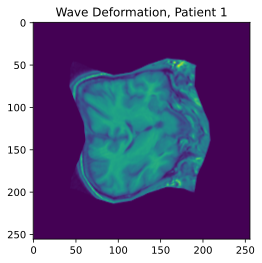

In [29]:
x1 = S1img[0]
deltac = 10*np.sin(np.indices((10,10))[1])
deltar = 10*np.cos(np.indices((10,10))[0])
m = pwAffine(img = S1img[0], paramc = deltac, paramr = deltar, density = 10)#, grid = (300,300))
plt.imshow(m)
plt.title("Wave Deformation, Patient 1")
plt.show()

In [30]:
'''
Polynomial Transformation using Scikit-Image's piecewise affine transform
    To learn more, URL: https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=warp#skimage.transform.PolynomialTransform

This function takes the input coordinates (u,v) and maps them to an output coordinates (x,y) via polynomials:
    x = sum[j=0:order]( sum[i=0:j]( a_ji * u**(j - i) * v**i ))
    y = sum[j=0:order]( sum[i=0:j]( b_ji * u**(j - i) * v**i ))
Where order is the order of the polynomial.

    params:
        img - image we are transfroming
        coeff - coefficients for the polynomial transformation. Should be a 2*N array where
                N * 2 = (order + 1) * (order + 2). This defines our a_ji's and b_ji's
        interp - the interpolation method when calculating the piecewise affine
            0: nearest neighbor
            1: bilinear
            2: biquardatic
            etc...
    returns:
        polynomial affine transform of img with the specified parameters

'''
def polyTransform(img, coeff, interp = 1):
    # Reshape our input parameters to the correct shape for skimage
    coeff = coeff.reshape(2, int(len(coeff)/2))
    transform = tf.PolynomialTransform(params=coeff)
    # Perform the transformation
    outimage = tf.warp(img, transform, output_shape = (img.shape), preserve_range = True, order = interp)
    return outimage

<b> Loss Functions:</b>

In [31]:
'''
Returns the normalized Sum of Squared Differences between a transformed moving image and a fixed image.
NOTE: Images are scaled so the 'magnitude' of the image is 1 fore finding the SSD.

    params:
        tparam - the transformation parameters for the moving image as a 1-D tuple or list.
                 MUST correspond the the specified transformation function - Transform
        mov - the moving image the transformation is performed on
        fix - the fixed image to compare with the moving image
        Transform - a transformation function we wish to use to transfrom mov
    returns:
        SSD between the transformed moving image and fixed image
'''
def SSD(tparam, mov, fix, Transform):
    # Transforming mov
    Tmov = Transform(mov, tparam)
    
    # Making the images length 1
    Tmov = Tmov/np.sqrt(np.sum(np.square(Tmov)))
    fix = fix/np.sqrt(np.sum(np.square(fix)))
    
    return np.sum(np.square(Tmov.astype(np.float64) - fix.astype(np.float64)))

In [32]:
'''
Returns the normalized Sum of Absolute Differences between a transformed moving image and a fixed image.
NOTE: Images are scaled so the 'magnitude' of the image is 1 fore finding the SAD.

    params:
        tparam - the transformation parameters for the moving image as a 1-D tuple or list.
                 MUST correspond the the specified transformation function - Transform
        mov - the moving image the transformation is performed on
        fix - the fixed image to compare with the moving image
        Transform - a transformation function we wish to use to transfrom mov
    returns:
        SAD between the transformed moving image and fixed image
'''
def SAD(tparam, mov, fix, Transform):
    # Transforming mov
    Tmov = Transform(mov, tparam)
    
    # Making the images length 1
    Tmov = Tmov/np.sqrt(np.sum(np.square(Tmov)))
    fix = fix/np.sqrt(np.sum(np.square(fix)))

    return np.sum(np.abs(Tmov.astype(np.float64) - fix.astype(np.float64)))

In [33]:
'''
This function is only used for a piecewise affine transformation!
Returns the normalized Sum of Absolute Differences between a transformed moving image and a fixed image.
NOTE: Images are scaled so the 'magnitude' of the image is 1 fore finding the SAD.

    params:
        tparam - the transformation parameters for the moving image as a 1-D tuple or list.
                 MUST correspond the the specified transformation function - Transform
        mov - the moving image the transformation is performed on
        fix - the fixed image to compare with the moving image
        density - the density of the piecewise affine transform
        typet - the mode of pw-Affine transformation we want to use
            'col': This mode means that we are only performing shifts on the columns of the input grid
            'row': This mode means that we are only performing shifts on the rows of the input grid
            None : This mode assumes that we are performing shifts on both rows and columns of input grid
    returns:
        SAD between the transformed moving image and fixed image
'''
def SADpw(tparam, mov, fix, density = 10, typet = None):
    # Reshape the parameters to the desired shape. Scipy optimize only allows 1-D vector parameters
        # pwAffine takes in DxD matrices for paramr and paramc (D=density)
    if(typet is None):
        tparam = tparam.reshape((2, density, density)) 
    elif(typet == 'col'):
        tparam = np.array([np.zeros((density, density)), tparam.reshape((density,density))])
    elif(typet == 'row'):
        tparam = np.array([tparam.reshape((density,density)), np.zeros((density, density))])
    paramr = tparam[0]
    paramc = tparam[1]
    
    # Perform the transformation
    Tmov = pwAffine(mov, paramr = paramr, paramc = paramc, grid = None, density = density)
    
    # Making the images length 1
    Tmov = Tmov/np.sqrt(np.sum(np.square(Tmov)))
    fix = fix/np.sqrt(np.sum(np.square(fix)))
    
    return np.sum(np.abs(Tmov.astype(np.float64) - fix.astype(np.float64)))

In [34]:
'''
This function is only used for a piecewise affine transformation!
Returns the normalized Sum of Squared Differences between a transformed moving image and a fixed image.
NOTE: Images are scaled so the 'magnitude' of the image is 1 fore finding the SSD.

    params:
        tparam - the transformation parameters for the moving image as a 1-D tuple or list.
                 MUST correspond the the specified transformation function - Transform
        mov - the moving image the transformation is performed on
        fix - the fixed image to compare with the moving image
        density - the density of the piecewise affine transform
        typet - the mode of pw-Affine transformation we want to use
            'col': This mode means that we are only performing shifts on the columns of the input grid
            'row': This mode means that we are only performing shifts on the rows of the input grid
            None : This mode assumes that we are performing shifts on both rows and columns of input grid
    returns:
        SSD between the transformed moving image and fixed image
'''
def SSDpw(tparam, mov, fix, density = 10, typet = None):
    # Reshape the parameters to the desired shape. Scipy optimize only allows 1-D vector parameters
        # pwAffine takes in DxD matrices for paramr and paramc (D=density)
    if(typet is None):
        tparam = tparam.reshape((2, density, density)) 
    elif(typet == 'col'):
        tparam = np.array([np.zeros((density, density)), tparam.reshape((density,density))])
    elif(typet == 'row'):
        tparam = np.array([tparam.reshape((density,density)), np.zeros((density, density))])
    paramr = tparam[0]
    paramc = tparam[1]
    
    # Perform the transformation
    Tmov = pwAffine(mov, paramr = paramr, paramc = paramc, grid = None, density = density)
    Tmov = Tmov/np.sqrt(np.sum(np.square(Tmov)))
    
    # Making the images length 1
    fix = fix/np.sqrt(np.sum(np.square(fix)))
    
    return np.sum(np.square(Tmov.astype(np.float64) - fix.astype(np.float64)))

<b> Optimization Functions:</b>

In [35]:
'''
Powell minimization function. This function finds the locally 'best' parameters for a desired transformation
    that will take a moving image, mov, as close as possible to the fixed image, fix, with respect to some
    loss metric, lossFunc using the Powell method. This is generally used for a normal Affine Transformation
    
    params:
        lossFunc - the loss metric we wish to minimize. This is the objective function to minimize
        fix - fixed image we want the make mov as close to as possible
        mov - moving image we want to transform as close to fix as possible
        Transform - the type of transformation we are using
        bounds - if we want to superinpose some bounds on our transformation, this parameter is used
    returns:
        tuple: (parameters for optimum transformation, optimal transformed mov image)    
'''
def optimizePowell(lossFunc, fix, mov, Transform, x0 = [1, 0, 0, 0, 1, 0]):
    # Initial values for the transformation is the identity transformation
    # Global tolerance set to 10**-4 based on what values our loss function returns
    oparam = sp.optimize.minimize(fun=lossFunc, x0=x0, method='Powell', args = (mov, fix, Transform),
                                 options={'maxiter': 10**10, 'maxfev': 10**10, 'xtol': 10**-4, 'ftol': 10**-4})
    
    return (oparam['x'], Transform(mov, oparam['x']))

In [36]:
'''
Nelder-Mead  minimization function. This function finds the locally 'best' parameters for a desired transformation
    that will take a moving image, mov, as close as possible to the fixed image, fix, with respect to some
    loss metric, lossFunc using the Nelder-Mead method. This is generally used for a normal Affine Transformation
    
    params:
        lossFunc - the loss metric we wish to minimize. This is the objective function to minimize
        fix - fixed image we want the make mov as close to as possible
        mov - moving image we want to transform as close to fix as possible
        Transform - the type of transformation we are using
        isim - the initial simplex we wish to use for our nelder mead optimization
            NOTE: shape should be (N+1, N) where N is the number of parameters we wish to optimize.
                    First row should be identity transformation.
                    Rest of the rows should define the N-Dimensional initial simplex
    returns:
        tuple: (parameters for optimum transformation, optimal transformed mov image, loss function value at min)    
'''
def optimizeNM(lossFunc, fix, mov, isim, Transform, x0 = [1, 0, 0, 0, 1, 0]):
    # Initial values for the transformation is the identity transformation
    # Global tolerance set to 10**-4 based on what values our loss function returns
    oparam = sp.optimize.minimize(fun=lossFunc, x0=x0, method='Nelder-Mead', 
                                  args = (mov, fix, Transform),
                                 options = {'initial_simplex': isim, 'maxiter': 10**10, 
                                            'xatol': 10**-4, 'fatol': 10**-4})
    
    return (oparam['x'], Transform(mov, oparam['x']), oparam['fun'])

In [37]:
'''
Nelder-Mead  minimization function. This function finds the locally 'best' parameters for a piecewise affine transform
    that will take a moving image, mov, as close as possible to the fixed image, fix, with respect to the
    sum of absolute difference metric using the Nelder-Mead method.
    NOTE: the SAD is fixed in this case because I have determined that the SSD metric is strictly worse
    
    params:
        fix - fixed image we want the make mov as close to as possible
        mov - moving image we want to transform as close to fix as possible
        density - the density of the piecewise affine transform we wish to optimize
        typet - the mode of pw-Affine transformation we want to use
            'col': This mode means that we are only performing shifts on the columns of the input grid
            'row': This mode means that we are only performing shifts on the rows of the input grid
            None : This mode assumes that we are performing shifts on both rows and columns of input grid
    returns:
        tuple: (parameters for optimum transformation, optimal transformed mov image)    
'''
def optimizeNMpw(fix, mov, density, typet = None):
#     isim - the initial simplex we wish to use for our nelder mead optimization
#             NOTE: shape should be (N+1, N) where N is the number of parameters we wish to optimize.
#                     First row should be identity transformation.
#                     Rest of the rows should define the N-Dimensional initial simplex
    isim = None
    x0 = None
    size = None
    
    # Finding a suitible initial simplex depending on the mode of pwAffine we are using
    if(typet is None):
        # For both 𝛿x and 𝛿y, both x and y requires a DxD grid where D = density
        size = 2*density*density
    elif(typet == 'row' or typet == 'col'):
        # For only 𝛿x or 𝛿y, both x or y requires a DxD grid where D = density
        size = density*density
    isim = [np.zeros(size)]
    # The first row is the identity transform
    # The rest of the rows essentially form an identity matrix scaled by 0.5
        # It was determined that this is a suitible initial simplex for optimization
    for i in range(0, size):
        sim = np.zeros(size)
        sim[i] = 0.5
        isim.append(sim)
    isim = np.array(isim)
    
    # This is the identity transformation. 𝛿x, 𝛿y, or both are all 0 
    x0 = np.zeros(size)
    
    # Global tolerance is set to 10**-3 because this function takes a considerable time to run
    oparam = sp.optimize.minimize(fun=SADpw, x0 = x0, method='Nelder-Mead', 
                                  args = (mov, fix, density, typet),
                                 options = {'initial_simplex': isim, 'maxiter': 10**10, 
                                            'xatol': 10**-3, 'fatol': 10**-3})
    
    # Reshaping optimal parameters to suitible shapes for pwAffine function
    params = oparam['x']
    if(typet is None):
        params = params.reshape((2, density, density))
    else:
        params = params.reshape((density, density))
        if(typet == 'row'):
            params = np.array([params, np.zeros((density, density))])
        else:
            params = np.array([np.zeros((density, density)), params])
            
    img = pwAffine(mov, paramr = params[0], paramc = params[1], density = density)
    
    return (params, img)

In [38]:
'''
Powell  minimization function. This function finds the locally 'best' parameters for a piecewise affine transform
    that will take a moving image, mov, as close as possible to the fixed image, fix, with respect to the
    sum of absolute difference metric using the Powell method.
    NOTE: the SAD is fixed in this case because I have determined that the SSD metric is strictly worse
    
    params:
        fix - fixed image we want the make mov as close to as possible
        mov - moving image we want to transform as close to fix as possible
        density - the density of the piecewise affine transform we wish to optimize
        typet - the mode of pw-Affine transformation we want to use
            'col': This mode means that we are only performing shifts on the columns of the input grid
            'row': This mode means that we are only performing shifts on the rows of the input grid
            None : This mode assumes that we are performing shifts on both rows and columns of input grid
    returns:
        tuple: (parameters for optimum transformation, optimal transformed mov image)    
'''
def optimizePowellpw(fix, mov, density, typet = None):
    # Finding the number of parameters we need to optimize
    x0 = None
    size = None
    if(typet is None):
        # For both 𝛿x and 𝛿y, both x and y requires a DxD grid where D = density
        size = 2*density*density
    else:
        # For only 𝛿x or 𝛿y, both x or y requires a DxD grid where D = density
        size = density*density
        
    # This is the identity transformation. 𝛿x, 𝛿y, or both are all 0
    x0 = np.zeros(size)
    
    # Performing optimization
    oparam = sp.optimize.minimize(fun=SADpw, x0=x0, method='Powell', 
                                  args = (mov, fix, density, typet),
                                  options={'maxiter': 10**10, 'maxfev': 10**10, 'xtol': 10**-4, 'ftol': 10**-4})
    
    # Reshaping optimal parameters to suitible shapes for pwAffine function
    params = oparam['x']
    if(typet is None):
        params = params.reshape((2, density, density))
    else:
        params = params.reshape((density, density))
        if(typet == 'row'):
            params = np.array([params, np.zeros((density, density))])
        else:
            params = np.array([np.zeros((density, density)), params])
            
    img = pwAffine(mov, paramr = params[0], paramc = params[1], density = density)
    
    return (params, img)

<b> Segmentation Functions: </b>

In [39]:
'''
Majority based segmentation. Given a set of candidate segmentations, the true pixel value for a given pixel
    is determined by the mode of the intensity values across all candidate segmentations.
    
    params:
        td - A stack of 6 candidate segmentations (because we have 6 pieces of training data)
    returns:
        A final segmentation result
'''
def majLFSeg(td):
    # First initialize an empty image in the desired shape of our segmentation
    shape = td[0].shape
    result = np.zeros(shape)
    
    # For each pixel in the resultant segmentation, determine the true value of the pixel intensity
    for i in range(shape[0]):
        for j in range(shape[1]):
            # Find the mode intensity across all segmentations for this pixel
            arr = np.zeros(6, dtype = np.int)
            for k in range(0,6):
                arr[k] = (td[k])[i][j]
            result[i][j] = np.argmax(np.bincount(arr))
            
    return result

In [40]:
'''
Weighted majority based segmentation. Given a set of candidate segmentations, the true pixel value for a given pixel
    is determined by the number of votes for each possible intensity value across all candidate segmentations.
The particular candidate segmentation has given 'weight' to its votes determed by user input.
    
    params:
        td - A stack of 6 candidate segmentations (because we have 6 pieces of training data)
        params - weights assigned to each candidate segmentation's vote
            NOTE: This function assumes that td's stack order is in order of patients 1-6
    returns:
        A final segmentation result
'''
def wmajLFSeg(td, params = [1, 1, 1, 1, 1, 1]): 
    # First initialize an empty image in the desired shape of our segmentation
    shape = td[0].shape
    result = np.zeros(shape)
    
    # For each pixel in the resultant segmentation, determine the true value of the pixel intensity
    for i in range(shape[0]):
        for j in range(shape[1]):
            # Find the weighted mode intensity across all segmentations for this pixel
            arr = np.zeros(6, dtype = np.int)
            for k in range(0,6):
                arr[k] = (td[k])[i][j]
            bins = np.bincount(arr, weights = params)
            result[i][j] = np.argmax(bins) 
            
    return result

In [41]:
'''
For a given image, add all the values of a 3x3 neighborhood of a specific coordinate into a given array

    params:
        img - image that we are looking at
        coord - coordinate of pixel we want to find the neighborhood of
        arr - array we want to append all the intensity values of the neighborhood to
    returns:
        The array arr with the 9 new appended values corresponding to the intensity values of the
            neighborhood around coord in img
'''
def localPatch(img, coord, arr):
    # Perform zero padding for pixels close to edge of image to prevent errors.
    # Renormalize coordinate to this new image
    img = np.pad(img, ((1,1),(1,1)), 'constant')
    coord = coord+1
    i = coord[0]
    j = coord[1]
    
    # Add the neighborhood intensity values to arr
    patch = np.ndarray.flatten(img[i-1:i+2, j-1:j+2])
    arr.extend(patch)
    return arr

In [42]:
'''
Majority based segmentation in a 3x3 neighbohood. Given a set of candidate segmentations, 
    the true pixel value for a given pixel is determined by the mode of the intensity values across all 
    candidate segmentations in a 3x3 neighborhood of that pixel. This function also supports weights
    like wmajLFSeg
    
        params:
            index - pixel index in array we are performing correlation on
            params - weights of each of the pixels in the 3x3 grid.
                NOTE: the 1-D array's weights corresponds a 3x3x3 grid np.reshape((3,3,3))
                      meaning we can weight each pixel of the 3x3 neighborhood across 6 segmentations
        returns:
            perason correlation of two images at the pixel at index in a 3x3 grid
'''
def pmajSeg(td, params = np.ones(54)):
    # First initialize an empty image in the desired shape of our segmentation
    shape = td[0].shape
    result = np.zeros(shape)
    
    # For each pixel in the resultant segmentation, determine the true value of the pixel intensity
    for i in range(shape[0]):
        for j in range(shape[1]):
            # Find all the intensity values in the 3x3 neighborhood of this pixel across all 6 candidate segmentations
            # Then find the (weighted) mode
            arr = []
            for k in range(0,6):
                arr = localPatch(td[k], np.array([i, j]), arr)
            bins = np.bincount(np.array(arr), weights = params)
            
            result[i][j] = np.argmax(bins)
            
    return result

> This segmentation uses a local 11x11 grid and performs correlation between each training image and the image we want to perform segmentation on around each given pixel on each training segmentation images. The weights are the correlation coefficients. This makes sense because the more similar an image to the target image, the higher it should be weighted in deciding the pixel value for the target segmentation.
<br>
<br>
NOTE: The 11x11 grid was decided upon by trial and error
<br>
<br>
This function assumes that the order in which the training data is input in the td array is the order of patients 1-6.

In [43]:
'''
Computes pearson normalized correlation between timg and img at pixel at index = (i,j) in a 11x11 neighborhood
        params:
            index - pixel index in array we are performing correlation on
            timg, img - training and target image we perform correlation on
        returns:
            perason correlation of two images at the pixel at index in a 11x11 grid
'''
def corr(index, timg, img):
    # Zero padding for 11x11 grid
    # Renormalize coordinate/index to this new grid
    img = np.pad(img, ((5,5),(5,5)), 'constant')
    timg = np.pad(timg, ((5,5),(5,5)), 'constant')
    coord = np.array(index) + 5
    i = coord[0]
    j = coord[1]
    
    #only consider pixels that are nonzero on both images timg and img and apply the 11x11 grid
    mask = (img != 0) & (timg != 0)
    img = (img*mask)[i-5:i+6, j-5:j+6]
    timg = (timg*mask)[i-5:i+6, j-5:j+6]
    
    # Return the correlation
    result = sp.stats.pearsonr(np.ndarray.flatten(img), np.ndarray.flatten(timg))[0]
    
    # If the correlation is NAN, just make the weight 1 (this is the case for constant / zero chunks)
    if(np.isnan(result)):
        result = 1
    return result


In [44]:
'''
Correlation weighted voting Segmentation
        params:
            td - stack of all candidate segmentations
            img - image we want to perform segmentation on
            timg - stack of all transformed traning data
        returns:
            A final segmentation result
'''
def corSeg(td, img, timg):
    # First initialize an empty image in the desired shape of our segmentation
    shape = td[0].shape
    result = np.zeros(shape)
    
    # For each pixel in the resultant segmentation, determine the true value of the pixel intensity
    for i in range(shape[0]):
        for j in range(shape[1]): 
            #For every pixel in the image find most frequent pixel segmentation weighted by correlation
            arr = np.zeros(6, dtype = np.int)
            weights = []
            for k in range(0,6):
                arr[k] = (td[k])[i][j]
                weights.append(corr([i,j], timg[k], img))
            # Negative weights don't make sense so add 1 such that the smallest possible weight is 0
                # View this as shifting over your distribution by 1
            weights = np.array(weights) + 1
            bins = np.bincount(np.array(arr), weights = weights)
            
            result[i][j] = np.argmax(bins)
            
    return result

<b> Jaccard Overlap Functions </b>

In [45]:
#Here is a dictionary of all of the ROIs that we care about
ROIs = {'Left-Cerebral-Exterior': 1,
            'Left-Cerebral-White-Matter': 2,
            'Left-Cerebral-Cortex': 3,
            'Left-Lateral-Ventricle': 4,
            'Left-Inf-Lat-Vent': 5,
            'Left-Cerebellum-Exterior': 6,
            'Left-Cerebellum-White-Matter': 7,
            'Left-Cerebellum-Cortex': 8,
            'Left-Thalamus': 9,
            'Left-Thalamus-Proper': 10,
            'Left-Caudate': 11,
            'Left-Putamen': 12,
            'Left-Pallidum': 13,
            '3rd-Ventricle': 14,
            '4th-Ventricle': 15,
            'Brain-Stem': 16,
            'Left-Hippocampus': 17,
            'Left-Amygdala': 18,
            'Left-Insula': 19,
            'Left-Operculum': 20,
            'Line-1': 21,
            'Line-2': 22,
            'Line-3': 23,
            'CSF': 24,
            'Left-Lesion': 25,
            'Left-Accumbens-area': 26,
            'Left-Substancia-Nigra': 27,
            'Left-VentralDC': 28,
            'Left-undetermined': 29,
            'Left-vessel': 30,
            'Left-choroid-plexus': 31,
            'Left-F3orb': 32,
            'Left-lOg': 33,
            'Left-aOg': 34,
            'Left-mOg': 35,
            'Left-pOg': 36,
            'Left-Stellate': 37,
            'Left-Porg': 38,
            'Left-Aorg': 39,
            'Right-Cerebral-Exterior': 40,
            'Right-Cerebral-White-Matter': 41,
            'Right-Cerebral-Cortex': 42,
            'Right-Lateral-Ventricle': 43,
            'Right-Inf-Lat-Vent': 44,
            'Right-Cerebellum-Exterior': 45,
            'Right-Cerebellum-White-Matter': 46,
            'Right-Cerebellum-Cortex': 47,
            'Right-Thalamus': 48,
            'Right-Thalamus-Proper': 49,
            'Right-Caudate': 50,
            'Right-Putamen': 51,
            'Right-Pallidum': 52,
            'Right-Hippocampus': 53,
            'Right-Amygdala': 54,
            'Right-Insula': 55,
            'Right-Operculum': 56,
            'Right-Lesion': 57,
            'Right-Accumbens-area': 58,
            'Right-Substancia-Nigra': 59,
            'Right-VentralDC': 60
           }

In [46]:
'''
Calculates the Jacaard Overlap (intersection over union) an automatic and manual segmentation for a specific ROI
    params:
        auto - automatic segmentation image
        manual - manual segmentation image
        r - region of interest based on the dictionary in the above cell
    returns:
        Jaacard overlap for the two segmentations for ROI = r
'''
def JacOverlap(auto, manual, r):
    # Uses bitwise operators and '==' operators to make this function run faster
    r = ROIs[r]
    # All the pixels in auto and manual that are in r
    auto = auto == r
    manual = manual == r
    
    # Intersection is the bitwise 'and' of the two matrices above
    inter = np.sum(auto & manual)
    
    # Union is the bitwise 'or' of the two matrices above
    union = np.sum(auto | manual)
    
    return inter/union

In [60]:
'''
Calculates the Dice Coefficients (2|AUB|/(|A|+|B|)) an automatic and manual segmentation for a specific ROI
    params:
        auto - automatic segmentation image
        manual - manual segmentation image
        r - region of interest based on the dictionary in the above cell
    returns:
        Jaacard overlap for the two segmentations for ROI = r
'''
def Dice(auto, manual, r):
    Jacc = JacOverlap(auto, manual, r)
    return 2*Jacc/(Jacc+1)

<b> Pre-Processing Functions: </b>

In [47]:
'''
These next two functions are helper functions to an exact histogram specification function.
This is for tiebreakers by inspecting a small neighborhood (total of 4 pixels).

    params:
        xpad - padded version of the image we are performing histogram equalization on
        (i, j) - coordinate of pixel of interest (already scaled to the padded grid)
    returns:
        Average/Expected intensity of the 4 pixel neighborhood
'''
def w1val(xpad, i, j):
    # This is our first neighborhood filter/shape that we want to inspect
    w1mat = 1/4*np.array([[0, 1, 0],
                          [1, 1, 1],
                          [0, 1, 0]
                         ])
    
    # Isolate this neighborhood in our image around our pixel at i and j
    neix = xpad[i-1:i+2, j-1:j+2]
    
    # Return average intensity
    return np.sum(np.multiply(w1mat, neix))

In [48]:
'''
This function is a helper functions to an exact histogram specification function.
This is for tiebreakers by inspecting a small neighborhood (total of 9 pixels).

    params:
        xpad - padded version of the image we are performing histogram equalization on
        (i, j) - coordinate of pixel of interest (already scaled to the padded grid)
    returns:
        Average/Expected intensity of the 9 pixel neighborhood
'''
def w2val(xpad, i, j):
    # This is our first neighborhood filter/shape that we want to inspect
    w2mat =  w2 = 1/9*np.ones((3,3))
    
    # Isolate this neighborhood in our image around our pixel at i and j
    neix = xpad[i-1:i+2, j-1:j+2]
    
    # Return average intensity
    return np.sum(np.multiply(w2mat, neix))

In [49]:
'''
Exact Histrogram specification function. An image we want to perform histograms specification on is recolored such that
    its histogram looks the exact same as a template image.
    
    params:
        tmplate - template image. We use the histogram of this image as a template histogram for the input image
        inimg - input image we perform histogram specification for
    returns:
        Returns input image with its intensity values scaled such that it has the same histogram as the template
'''
def equalizeHist(tmplate, inimg):
    # We will trim the region that we are looking at so that we get less '0' values
        # Basically, localize region of interest to section that actually contains the MRI scan
        # We want to remove 0 values because it would saturate our histogram and make tiebreaking very difficult
    # Apply this trimming to both images (in general the amount trimmed isn't the same for each region)
    i1 = tmplate.any(1).argmax()
    i2 = tmplate.any(0).argmax()
    temp1=np.flip(tmplate, axis = 1)
    i3 = tmplate.shape[0] - temp1.any(1).argmax() + 1
    i4 = tmplate.shape[1] - temp1.any(0).argmax()
    tmplate = tmplate[i1:i3,i2:i4]
    
    f1 = inimg.any(1).argmax()
    f2 = inimg.any(0).argmax()
    img1=np.flip(inimg, axis = 1)
    f3 = inimg.shape[0] - img1.any(1).argmax() + 1
    f4 = inimg.shape[1] - img1.any(0).argmax()
    tempimg = inimg[f1:f3,f2:f4]   
    
    # Here is the histogram for the template image
        # This will be used as the number of pixels that should be in each bin
        # Number of pixels per bin are renormalized to the number of pixels in the input image
    hist = np.ndarray.astype(np.around(
        np.bincount(np.ndarray.flatten(tmplate))/np.size(tmplate)*np.size(tempimg), decimals=0), int)
    
    # Zero pad our input image
    shape = tempimg.shape
    imgpad = np.pad(tempimg, ((1,1),(1,1)), 'constant')
    
    # For each pixel in our image, find a corresponding intensity value with neighbor tiebreaking for w1 and w2
    w1 = np.zeros(shape)
    w2 = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            w1[i][j] = w1val(imgpad, i+1, j+1)
            w2[i][j] = w2val(imgpad, i+1, j+1)
            
    # Create an coordinate array for x and y coordinates so we can recreate the image from the specified histogram
    index = np.indices(shape)
    
    # Stack our images: tiebreaking 1, tiebreaking 2, x index, y index - then flatten the along image axis
    xbar = np.stack((tempimg, w1, w2, index[0], index[1]))
    xbar = xbar.reshape((5, tempimg.size))
    
    # Perform a sorting algorithm only based on the first tie arguments.
    # The np sort function takes in my newly structured ordered array and sorts based on tie1, tie2, tie3 in that order
    
    # After all pixels are sorted, take the result and make an array of indices in the correct order
    xbar = xbar.T
    xbar = xbar.ravel().view(dtype=[('tie1', float), ('tie2', float), 
                                    ('tie3', float), ('datax', float), ('datay', float)])
    xbar = np.sort(xbar, order=['tie1', 'tie2', 'tie3'], axis=0)
    xbar = np.array([xbar['datax'], xbar['datay']])
    xbar = np.ndarray.astype(xbar, np.int)
    
    # Reconstruct our image by removing columns from our ordered list xbar. 
        # The number of pixels per bin is given by the histogram of our template image
    finalimg = np.zeros(shape)
    for i in range(0, hist.size):
        for j in range(0, hist[i]):
            if(xbar.size == 0):
                break
            indx = int(xbar[0][0])
            indy = int(xbar[1][0])
            finalimg[indx][indy] = i
            xbar = xbar[:,1:]
    finalimg = np.ndarray.astype(finalimg, np.int)
    
    # Take the trimmed image and replace it on an empty black image to add the black grid back again
    mask = np.zeros(inimg.shape)
    
    mask[f1:f3,f2:f4] = finalimg
    
    return mask

<b> Method 1: </b>
<br>
> This is the original Milestone two pipeline a using general affine transformation instead which allows for shears.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- Find optimized affine transformation parameters for each training data w.r.t. SSD loss function
- Perform these optimized affine transformations one each of the training segmentations
- Each pixel in the output segementation is the majority of the specific pixel across all the transformed segmentations of the training data

In [25]:
def P1(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0],
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SSD, fix = img, mov = S1img[0], isim = isim, Transform = affineTransform)[0]
    reg2p = optimizeNM(lossFunc = SSD, fix = img, mov = S2img[0], isim = isim, Transform = affineTransform)[0]
    reg3p = optimizeNM(lossFunc = SSD, fix = img, mov = S3img[0], isim = isim, Transform = affineTransform)[0]
    reg4p = optimizeNM(lossFunc = SSD, fix = img, mov = S4img[0], isim = isim, Transform = affineTransform)[0]
    reg5p = optimizeNM(lossFunc = SSD, fix = img, mov = S5img[0], isim = isim, Transform = affineTransform)[0]
    reg6p = optimizeNM(lossFunc = SSD, fix = img, mov = S6img[0], isim = isim, Transform = affineTransform)[0]
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p)
    seg2 = affineTransform(S2seg[0], reg2p)
    seg3 = affineTransform(S3seg[0], reg3p)
    seg4 = affineTransform(S4seg[0], reg4p)
    seg5 = affineTransform(S5seg[0], reg5p)
    seg6 = affineTransform(S6seg[0], reg6p)
    
    # Make an array of all these segmented images so we can pass it to the majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    # Perform majority segmentation
    result = majLFSeg(S)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

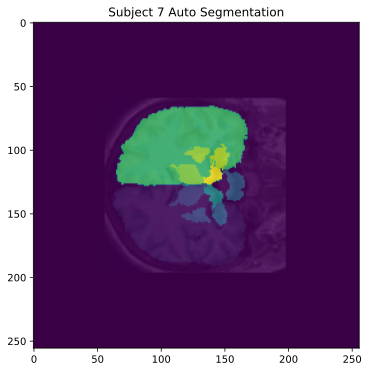

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.598510,0.608592
C. Cortex,0.644115,0.625367


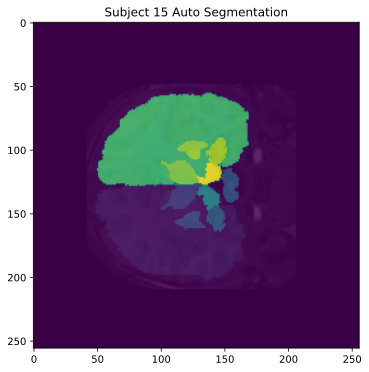

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.519909,0.581546
C. Cortex,0.402377,0.496696


In [26]:
S7, Jac7 = P1(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P1(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)


<b> Method 2: </b>
<br>
> This is the original Milestone two pipeline using general affine transformation instead. We also use a sum of absolute difference loss function instead of the sum of squared differences.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function
- Perform these optimized affine transformations one each of the training segmentations
- Each pixel in the output segementation is the majority of the specific pixel across all the transformed segmentations of the training data

In [27]:
def P2(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0],
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1img[0], isim = isim, Transform = affineTransform)[0]
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2img[0], isim = isim, Transform = affineTransform)[0]
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3img[0], isim = isim, Transform = affineTransform)[0]
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4img[0], isim = isim, Transform = affineTransform)[0]
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5img[0], isim = isim, Transform = affineTransform)[0]
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6img[0], isim = isim, Transform = affineTransform)[0]
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p)
    seg2 = affineTransform(S2seg[0], reg2p)
    seg3 = affineTransform(S3seg[0], reg3p)
    seg4 = affineTransform(S4seg[0], reg4p)
    seg5 = affineTransform(S5seg[0], reg5p)
    seg6 = affineTransform(S6seg[0], reg6p)
    
    # Make an array of all these segmented images so we can pass it to the majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    # Perform majority segmentation
    result = majLFSeg(S)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

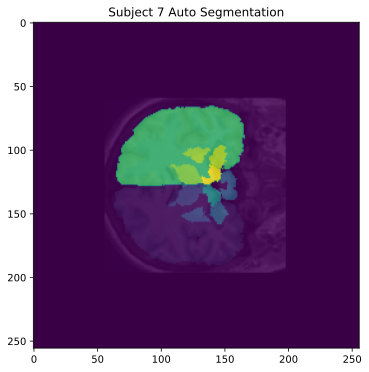

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.625000,0.641985
C. Cortex,0.642633,0.648669


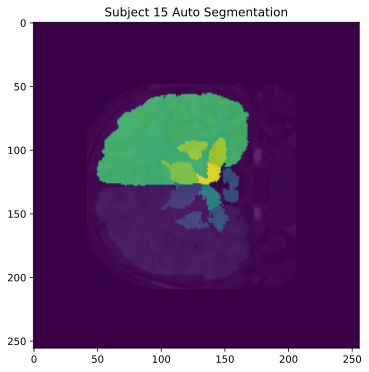

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.525194,0.600340
C. Cortex,0.436870,0.513321


In [28]:
S7, Jac7 = P2(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P2(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)


<b> Method 3: </b>
<br>
> This is the original Milestone two pipeline using general affine transformation instead. We also use a sum of absolute difference loss function instead of the sum of squared differences. To determine pixel values in our result segmentation, we use a weighted majority voting scheme.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function
- Perform these optimized affine transformations one each of the training segmentations
- Each pixel in the output segementation is the weighted majority of the specific pixel across all the transformed segmentations of the training data. The weights are determined by the loss values for each transformation.

***
What the last point means is that I will take take the LossFunc values for each of the segmented images and renormalize the max and min function to some distribution, lets say a sigmoid. The center average value of the function is the average value of the losses and from. I just messed around with some of the parameters for the sigmoid function until I got something that fit alright (coefficients on the exponents). This is not rigourous. I was just seeing if some distributions would give better results than others.

In [29]:
def P3(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1img[0], isim = isim, Transform = affineTransform)
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2img[0], isim = isim, Transform = affineTransform)
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3img[0], isim = isim, Transform = affineTransform)
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4img[0], isim = isim, Transform = affineTransform)
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5img[0], isim = isim, Transform = affineTransform)
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6img[0], isim = isim, Transform = affineTransform)
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p[0])
    seg2 = affineTransform(S2seg[0], reg2p[0])
    seg3 = affineTransform(S3seg[0], reg3p[0])
    seg4 = affineTransform(S4seg[0], reg4p[0])
    seg5 = affineTransform(S5seg[0], reg5p[0])
    seg6 = affineTransform(S6seg[0], reg6p[0])
    
    # Here is an array of all of the lossfunc values for each of these segmentations
        # Renormalize these loss values to a sigmoid like function
    L = np.array([reg1p[2], reg2p[2], reg3p[2], reg4p[2], reg5p[2], reg6p[2]])
    a = 1.1*np.min(L)
    b = 0.9*np.max(L)
    mid = (a+b)/2
    L = np.exp(1/3*(L-mid))/(1+np.exp(1/3*(L-mid)))
    
    # Make an array of all the segmented images so we can pass it to the majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    #Perform weighted majority segmentation
    result = wmajLFSeg(S, L)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

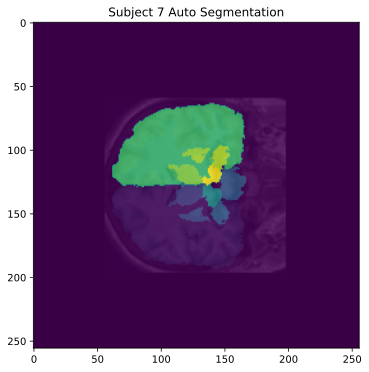

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.578145,0.576162
C. Cortex,0.616822,0.594292


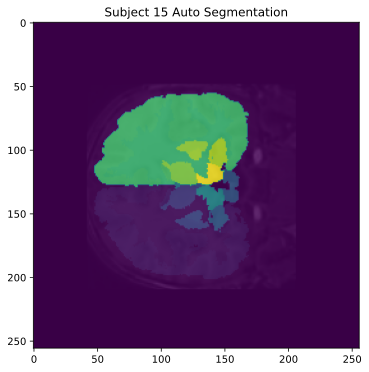

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.496646,0.558133
C. Cortex,0.442545,0.516444


In [30]:
S7, Jac7 = P3(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P3(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

I will say that I'm not sure exactly what sort of weights I should be using for the majority based voting, but this seems strictly worse than before.

<b> Method 4: </b>
<br>
> This is the original Milestone two pipeline using general affine transformation instead. We also use a sum of absolute difference loss function instead of the sum of squared differences. To determine pixel values in our result segmentation, we use a patch majority voting scheme.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function
- Perform these optimized affine transformations one each of the training segmentations
- For each pixel in the output segementation, intensities are the majority intensity in the neighborhood around the pixel across all the transformed segmentations of the training data in a 3x3 grid. This should theoretically minimize errors.

In [31]:
def P4(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0],
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1img[0], isim = isim, Transform = affineTransform)
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2img[0], isim = isim, Transform = affineTransform)
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3img[0], isim = isim, Transform = affineTransform)
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4img[0], isim = isim, Transform = affineTransform)
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5img[0], isim = isim, Transform = affineTransform)
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6img[0], isim = isim, Transform = affineTransform)
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p[0])
    seg2 = affineTransform(S2seg[0], reg2p[0])
    seg3 = affineTransform(S3seg[0], reg3p[0])
    seg4 = affineTransform(S4seg[0], reg4p[0])
    seg5 = affineTransform(S5seg[0], reg5p[0])
    seg6 = affineTransform(S6seg[0], reg6p[0])
    
    # Make an array of all these segmented images so we can pass it to the majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    # Perform patch majority segmentation scheme
    result = pmajSeg(S)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

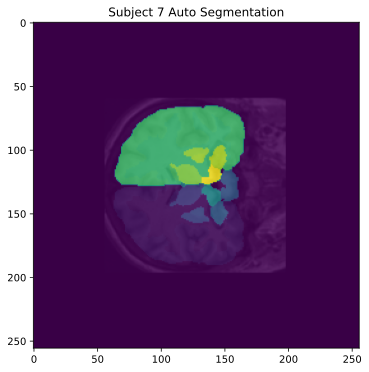

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.619521,0.620530
C. Cortex,0.668229,0.652807


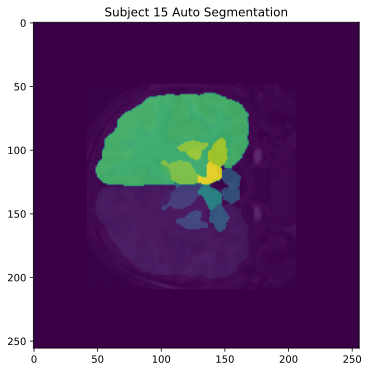

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.511780,0.583407
C. Cortex,0.465049,0.541560


In [32]:
S7, Jac7 = P4(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P4(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

<b> Method 5: </b>
>Preprocessing applied
<br>
> This is the original Milestone two pipeline using general affine transformation instead. We also use a sum of absolute difference loss function instead of the sum of squared differences. To determine pixel values in our result segmentation, we use a patch majority voting scheme. Additionally, each training image is histogram specified to the input image's histogram.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- First, for each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function
- Perform these optimized affine transformations one each of the training segmentations
- For each pixel in the output segementation, intensities are the majority intensity in the neighborhood around the pixel across all the transformed segmentations of the training data in a 3x3 grid. This should theoretically minimize errors.

In [33]:
def P5(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Match all the training images to the input image
    S1 = equalizeHist(img, S1img[0])
    S2 = equalizeHist(img, S2img[0])
    S3 = equalizeHist(img, S3img[0])
    S4 = equalizeHist(img, S4img[0])
    S5 = equalizeHist(img, S5img[0])
    S6 = equalizeHist(img, S6img[0])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1, isim = isim, Transform = affineTransform)
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2, isim = isim, Transform = affineTransform)
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3, isim = isim, Transform = affineTransform)
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4, isim = isim, Transform = affineTransform)
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5, isim = isim, Transform = affineTransform)
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6, isim = isim, Transform = affineTransform)
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p[0])
    seg2 = affineTransform(S2seg[0], reg2p[0])
    seg3 = affineTransform(S3seg[0], reg3p[0])
    seg4 = affineTransform(S4seg[0], reg4p[0])
    seg5 = affineTransform(S5seg[0], reg5p[0])
    seg6 = affineTransform(S6seg[0], reg6p[0])
    
    # Make an array of all these segmented images so we can pass it to the majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    # Perform patch majority segmentation
    result = pmajSeg(S)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

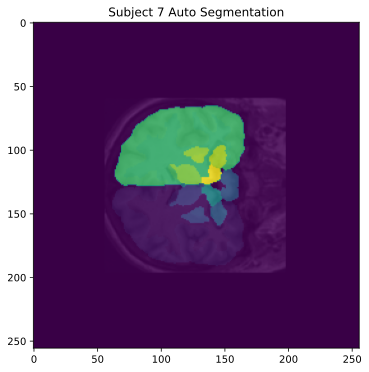

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.622001,0.622889
C. Cortex,0.670113,0.649591


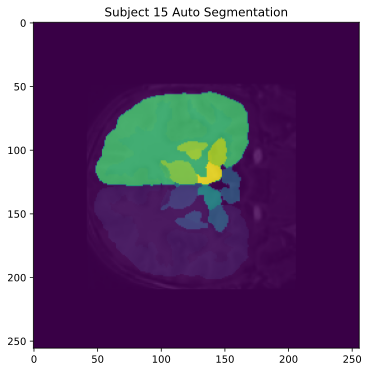

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.513041,0.591162
C. Cortex,0.477410,0.555026


In [34]:
S7, Jac7 = P5(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P5(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

<b> Method 6: (Warning: Long Run Time)</b>
>Preprocessing applied
<br>
> This is the original Milestone two pipeline using general affine transformation instead. We also use a sum of absolute difference loss function instead of the sum of squared differences. To determine pixel values in our result segmentation, we use a correlational weighted majority voting scheme. Additionally, each training image is histogram specified to the input image's histogram.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- First, for each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function
- Perform these optimized affine transformations one each of the training segmentations
- Each pixel intensity in the output segementation is the weighted majority of the same pixels across all the transformed segmentations of the training images with weights based on correlation of that training image with the original image. Correlation is per pixel and based on an 11x11 neighborhood. 11x11 was determined bye experimentation. This should theoretically reduce errors.

In [35]:
def P6(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Match all the training images to the input image
    S1 = equalizeHist(img, S1img[0])
    S2 = equalizeHist(img, S2img[0])
    S3 = equalizeHist(img, S3img[0])
    S4 = equalizeHist(img, S4img[0])
    S5 = equalizeHist(img, S5img[0])
    S6 = equalizeHist(img, S6img[0])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1, isim = isim, Transform = affineTransform)
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2, isim = isim, Transform = affineTransform)
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3, isim = isim, Transform = affineTransform)
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4, isim = isim, Transform = affineTransform)
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5, isim = isim, Transform = affineTransform)
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6, isim = isim, Transform = affineTransform)
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p[0])
    seg2 = affineTransform(S2seg[0], reg2p[0])
    seg3 = affineTransform(S3seg[0], reg3p[0])
    seg4 = affineTransform(S4seg[0], reg4p[0])
    seg5 = affineTransform(S5seg[0], reg5p[0])
    seg6 = affineTransform(S6seg[0], reg6p[0])
    
    # Make an array of all these segmented and transformed training 
        # images so we can pass it to the weighted majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    timg = np.array([reg1p[1], reg2p[1], reg3p[1], reg4p[1], reg5p[1], reg6p[1]])
    
    # Perform correlation majority segmentation
    result = corSeg(td = S, timg = timg, img = img)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    #else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


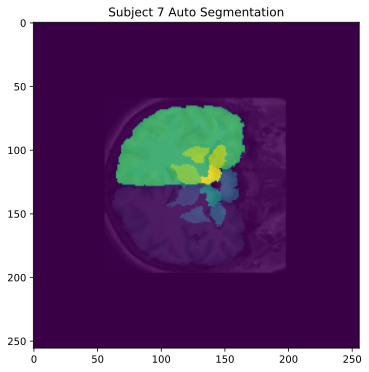

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.650508,0.635863
C. Cortex,0.691162,0.661926


C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


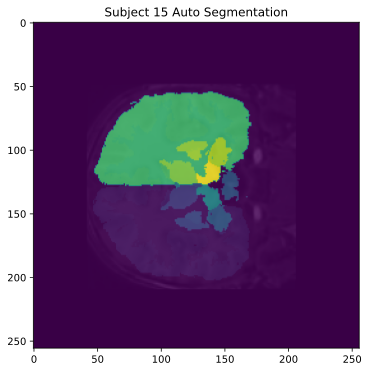

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.532491,0.609189
C. Cortex,0.502757,0.582573


In [36]:
S7, Jac7 = P6(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P6(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

<b> Method 7: (Warning: Long Run Time)</b>
>Preprocessing applied
<br>
> This method uses a normal and piecewise affine transformations. We also use a sum of absolute difference loss function instead of the sum of squared differences. To determine pixel values in our result segmentation, we use a correlational weighted majority voting scheme. Additionally, each training image is histogram specified to the input image's histogram.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- First, for each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function 
- Perform these optimized affine transformations one each of the training images and remove pixels that don't exist in both the transformed moving image and fixed image (0 value pixels)
- Take these optimized training images and learn a new transformation, a piecewise affine transformation with fixed points on a 4x4 grid first on the rows only, then on the columns only. I have determined that doing it with x and then y works better than optimizing both at the same time
- For all the training segmentations, first perform the affine trasformation, then compose it with the two piecewise affine transformations. 
- Each pixel intensity in the output segementation is the weighted majority of the same pixels across all the transformed segmentations of the training images with weights based on correlation of that training image with the original image. Correlation is per pixel and based on an 11x11 neighborhood. 11x11 was determined bye experimentation. This should theoretically reduce errors.

In [150]:
def P7(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0],
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Match all the training images to the input image
    S1 = equalizeHist(img, S1img[0])
    S2 = equalizeHist(img, S2img[0])
    S3 = equalizeHist(img, S3img[0])
    S4 = equalizeHist(img, S4img[0])
    S5 = equalizeHist(img, S5img[0])
    S6 = equalizeHist(img, S6img[0])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1, isim = isim, Transform = affineTransform)
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2, isim = isim, Transform = affineTransform)
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3, isim = isim, Transform = affineTransform)
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4, isim = isim, Transform = affineTransform)
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5, isim = isim, Transform = affineTransform)
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6, isim = isim, Transform = affineTransform)
    
    # I separated the actual resultant images from the optimization above for use later
    # Remove pixels that don't exist in both the affine transformed image and fixed image
        # this is to prevent the pw affine from doing unecessary stretching and distorging of the image if the 
        # sizes are too different. This is because a 4x4 grid is small enough to cause wierd stretching
    a1 = reg1p[1]
    mask1 = (a1 != 0) & (img != 0)
    img1 = img*mask1
    a1 = a1*mask1
    
    a2 = reg2p[1]
    mask2 = (a2 != 0) & (img != 0)
    img2 = img*mask2
    a2 = a2*mask2
    
    a3 = reg3p[1]
    mask3 = (a3 != 0) & (img != 0)
    img3 = img*mask3
    a3 = a3*mask3
    
    a4 = reg4p[1]
    mask4 = (a4 != 0) & (img != 0)
    img4 = img*mask4
    a4 = a4*mask4
    
    a5 = reg5p[1]
    mask5 = (a5 != 0) & (img != 0)
    img5 = img*mask5
    a5 = a5*mask5
    
    a6 = reg6p[1]
    mask6 = (a6 != 0) & (img != 0)
    img6 = img*mask6
    a6 = a6*mask6
    
    # Learn piecewise affine transformations for each of the resultant affine transformed images alow the rows
        # Resultant images are then stored for use in piecewise column transforms
    pwr1 = optimizePowellpw(fix = img1, mov = a1, density = 4, typet = 'row')
    p1r = pwr1[1]
    pwr1 = pwr1[0]
    pwr1 = pwr1.reshape((2, 4, 4)) #reshape output parameters to desirable shape
    
    pwr2 = optimizePowellpw(fix = img2, mov = a2, density = 4, typet = 'row')
    p2r = pwr2[1]
    pwr2 = pwr2[0]
    pwr2 = pwr2.reshape((2, 4, 4))
    
    pwr3 = optimizePowellpw(fix = img3, mov = a3, density = 4, typet = 'row')
    p3r = pwr3[1]
    pwr3 = pwr3[0]
    pwr3 = pwr3.reshape((2, 4, 4))
    
    pwr4 = optimizePowellpw(fix = img4, mov = a4, density = 4, typet = 'row')
    p4r = pwr4[1]
    pwr4 = pwr4[0]
    pwr4 = pwr4.reshape((2, 4, 4))
    
    pwr5 = optimizePowellpw(fix = img5, mov = a5, density = 4, typet = 'row')
    p5r = pwr5[1]
    pwr5 = pwr5[0]
    pwr5 = pwr5.reshape((2, 4, 4))
    
    pwr6 = optimizePowellpw(fix = img6, mov = a6, density = 4, typet = 'row')
    p6r = pwr6[1]
    pwr6 = pwr6[0]
    pwr6 = pwr6.reshape((2, 4, 4))
    
    # Learn piecewise affine transformations for each of the resultant affine transformed images along the columns
        # Resultant images are then stored for use in majority weights
    pwc1 = optimizePowellpw(fix = img1, mov = p1r, density = 4, typet = 'col')
    p1c = pwc1[1]
    pwc1 = pwc1[0]
    pwc1 = pwc1.reshape((2, 4, 4))
    
    pwc2 = optimizePowellpw(fix = img2, mov = p2r, density = 4, typet = 'col')
    p2c = pwc2[1]
    pwc2 = pwc2[0]
    pwc2 = pwc2.reshape((2, 4, 4))
    
    pwc3 = optimizePowellpw(fix = img3, mov = p3r, density = 4, typet = 'col')
    p3c = pwc3[1]
    pwc3 = pwc3[0]
    pwc3 = pwc3.reshape((2, 4, 4))
    
    pwc4 = optimizePowellpw(fix = img4, mov = p4r, density = 4, typet = 'col')
    p4c = pwc4[1]
    pwc4 = pwc4[0]
    pwc4 = pwc4.reshape((2, 4, 4))
    
    pwc5 = optimizePowellpw(fix = img5, mov = p5r, density = 4, typet = 'col')
    p5c = pwc5[1]
    pwc5 = pwc5[0]
    pwc5 = pwc5.reshape((2, 4, 4))
    
    pwc6 = optimizePowellpw(fix = img6, mov = p6r, density = 4, typet = 'col')
    p6c = pwc6[1]
    pwc6 = pwc6[0]
    pwc6 = pwc6.reshape((2, 4, 4))
    
    # Perform the composition of the affine transformation then the piecewise affine on each segmentation
    seg1 = affineTransform(S1seg[0], reg1p[0])
    seg1 = pwAffine(img = seg1, paramr = pwr1[0], paramc = pwc1[1], grid = None, density = 4, order = 0)
    seg2 = affineTransform(S2seg[0], reg2p[0])
    seg2 = pwAffine(img = seg2, paramr = pwr2[0], paramc = pwc2[1], grid = None, density = 4, order = 0)
    seg3 = affineTransform(S3seg[0], reg3p[0])
    seg3 = pwAffine(img = seg3, paramr = pwr3[0], paramc = pwc3[1], grid = None, density = 4, order = 0)
    seg4 = affineTransform(S4seg[0], reg4p[0])
    seg4 = pwAffine(img = seg4, paramr = pwr4[0], paramc = pwc4[1], grid = None, density = 4, order = 0)
    seg5 = affineTransform(S5seg[0], reg5p[0])
    seg5 = pwAffine(img = seg5, paramr = pwr5[0], paramc = pwc5[1], grid = None, density = 4, order = 0)
    seg6 = affineTransform(S6seg[0], reg6p[0])
    seg6 = pwAffine(img = seg6, paramr = pwr6[0], paramc = pwc6[1], grid = None, density = 4, order = 0)
    
    
    # Make an array of all these segmented and transformed training 
        # images so we can pass it to the weighted majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    timg = np.array([p1c, p2c, p3c, p4c, p5c, p6c])
    
    # Perform majority segmentation
    result = corSeg(td = S, timg = timg, img = img)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


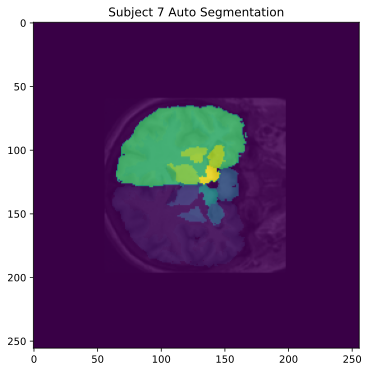

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.669291,0.648766
C. Cortex,0.691969,0.663162


C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


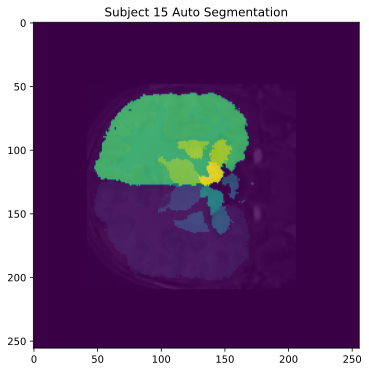

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.556836,0.594281
C. Cortex,0.521384,0.564982


In [39]:
S7, Jac7 = P7(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P7(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

<b> Method 8: (Warning: Long Run Time)</b>
>Preprocessing applied
<br>
> This method uses an affine and polynomial transformation. We also use a sum of absolute difference loss function instead of the sum of squared differences. To determine pixel values in our result segmentation, we use a correlational weighted majority voting scheme. Additionally, each training image is histogram specified to the input image's histogram.
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- First, for each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find optimized affine transformation parameters for each training data w.r.t. SAD loss function 
- Perform these optimized affine transformations one each of the training images and remove pixels that don't exist in both the transformed moving image and fixed image (0 value pixels)
- Take these optimized training images and learn a new transformation, a polynomial transformation with order 3 polynomials
- For all the training segmentations, first perform the affine trasformation, then compose it with the polynomial transform. 
- Each pixel intensity in the output segementation is the weighted majority of the same pixels across all the transformed segmentations of the training images with weights based on correlation of that training image with the original image. Correlation is per pixel and based on an 11x11 neighborhood. 11x11 was determined by experimentation. This should theoretically reduce errors.

In [151]:
def P8(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    order = np.int((3 + 1)*(3 + 2)/2)
    x0 = np.zeros((2, order))
    x0[0][1] = 1
    x0[1][2] = 1
    x0 = np.ndarray.flatten(x0)
    iden = 0.4*np.identity(len(x0)) + x0
    isimPoly = np.vstack([x0, iden])
    
    # Match all the training images to the input image
    S1 = equalizeHist(img, S1img[0])
    S2 = equalizeHist(img, S2img[0])
    S3 = equalizeHist(img, S3img[0])
    S4 = equalizeHist(img, S4img[0])
    S5 = equalizeHist(img, S5img[0])
    S6 = equalizeHist(img, S6img[0])
    
    # Perform segmentation and take the parameters for the affine transformation
    reg1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1, isim = isim, Transform = affineTransform)
    reg2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2, isim = isim, Transform = affineTransform)
    reg3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3, isim = isim, Transform = affineTransform)
    reg4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4, isim = isim, Transform = affineTransform)
    reg5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5, isim = isim, Transform = affineTransform)
    reg6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6, isim = isim, Transform = affineTransform)
    
     # Remove pixels that don't exist in both the affine transformed image and fixed image
        # this is to prevent the polynomial affine from doing unecessary stretching and distorging of the image if the 
        # sizes are too different.
    a1 = reg1p[1]
    mask1 = (a1 != 0) & (img != 0)
    img1 = img*mask1
    a1 = a1*mask1
    
    a2 = reg2p[1]
    mask2 = (a2 != 0) & (img != 0)
    img2 = img*mask2
    a2 = a2*mask2
    
    a3 = reg3p[1]
    mask3 = (a3 != 0) & (img != 0)
    img3 = img*mask3
    a3 = a3*mask3
    
    a4 = reg4p[1]
    mask4 = (a4 != 0) & (img != 0)
    img4 = img*mask4
    a4 = a4*mask4
    
    a5 = reg5p[1]
    mask5 = (a5 != 0) & (img != 0)
    img5 = img*mask5
    a5 = a5*mask5
    
    a6 = reg6p[1]
    mask6 = (a6 != 0) & (img != 0)
    img6 = img*mask6
    a6 = a6*mask6
    
    reg1poly = optimizeNM(lossFunc = SAD, fix = img1, mov = a1, isim = isimPoly, Transform = polyTransform, x0 = x0)
    reg2poly = optimizeNM(lossFunc = SAD, fix = img2, mov = a2, isim = isimPoly, Transform = polyTransform, x0 = x0)
    reg3poly = optimizeNM(lossFunc = SAD, fix = img3, mov = a3, isim = isimPoly, Transform = polyTransform, x0 = x0)
    reg4poly = optimizeNM(lossFunc = SAD, fix = img4, mov = a4, isim = isimPoly, Transform = polyTransform, x0 = x0)
    reg5poly = optimizeNM(lossFunc = SAD, fix = img5, mov = a5, isim = isimPoly, Transform = polyTransform, x0 = x0)
    reg6poly = optimizeNM(lossFunc = SAD, fix = img6, mov = a6, isim = isimPoly, Transform = polyTransform, x0 = x0)
    
    # Perform affine transformation on all of the segmentation images
    seg1 = affineTransform(S1seg[0], reg1p[0])
    seg1 = polyTransform(seg1, reg1poly[0], interp = 0)
    seg2 = affineTransform(S2seg[0], reg2p[0])
    seg2 = polyTransform(seg2, reg2poly[0], interp = 0)
    seg3 = affineTransform(S3seg[0], reg3p[0])
    seg3 = polyTransform(seg3, reg3poly[0], interp = 0)
    seg4 = affineTransform(S4seg[0], reg4p[0])
    seg4 = polyTransform(seg4, reg4poly[0], interp = 0)
    seg5 = affineTransform(S5seg[0], reg5p[0])
    seg5 = polyTransform(seg5, reg5poly[0], interp = 0)
    seg6 = affineTransform(S6seg[0], reg6p[0])
    seg6 = polyTransform(seg6, reg6poly[0], interp = 0)
    
    # Make an array of all these segmented and transformed training 
        # images so we can pass it to the weighted majority segmentation function
    S = np.array([seg1, seg2, seg3, seg4, seg5, seg6])
    
    timg = np.array([reg1poly[1], reg2poly[1], reg3poly[1], reg4poly[1], reg5poly[1], reg6poly[1]])
    
    # Perform correlation majority segmentation
    result = corSeg(td = S, timg = timg, img = img)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    #else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

C:\Users\Hamilton Lee\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


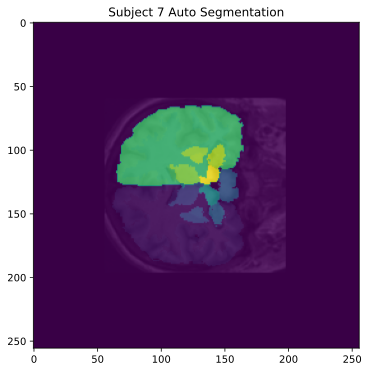

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.657737,0.639829
C. Cortex,0.682621,0.647037


C:\Users\Hamilton Lee\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


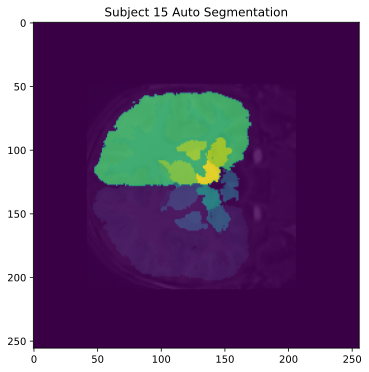

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.539699,0.602663
C. Cortex,0.504474,0.574913


In [152]:
S7, Jac7 = P8(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P8(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

<b> Method 9: (Warning: Long Run Time)</b>
>Preprocessing applied
<br>
> This method finds a diffeomorphic deformation on the image coordinates that transforms the moving image to the fixed. A diffeomorphism is a isomorphism on differentiable manifolds (every point is locally similar to an euclidean space). We also use a sum of absolute squared loss function. The optimization is performed through a demons algorithm based on optical flow. To determine pixel values in our result segmentation, we use a correlational weighted majority voting scheme. Additionally, each training image is denoised and is histogram specified to the input image's histogram. This link helped me learn how to use the library.
<br>
URL: https://simpleitk.readthedocs.io/en/master/link_DemonsRegistration1_docs.html
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- For each image including the input, perform a smoothing operation that gets decreases MRI inhomogeneity
- For each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find an optimized diffeomorphism that takes each moving image to the fixed image
- Perform these optimized transformations one each of the training images
- For all the training segmentations, perform the transformation
- Each pixel intensity in the output segementation is the weighted majority of the same pixels across all the transformed segmentations of the transformed training images with weights based on correlation of that training image with the original image. Correlation is per pixel and based on an 11x11 neighborhood. 11x11 was determined by experimentation. This should theoretically reduce errors.

In [189]:
def P9(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    # Perform mean Denoising on all the MRI scans
    img = mean_bilateral(img.astype(np.uint16), disk(20), s0=10, s1=10)
    S1 = mean_bilateral(S1img[0].astype(np.uint16), disk(20), s0=10, s1=10)
    S2 = mean_bilateral(S2img[0].astype(np.uint16), disk(20), s0=10, s1=10)
    S3 = mean_bilateral(S3img[0].astype(np.uint16), disk(20), s0=10, s1=10)
    S4 = mean_bilateral(S4img[0].astype(np.uint16), disk(20), s0=10, s1=10)
    S5 = mean_bilateral(S5img[0].astype(np.uint16), disk(20), s0=10, s1=10)
    S6 = mean_bilateral(S6img[0].astype(np.uint16), disk(20), s0=10, s1=10)
    
    # First find an affine transform for each of the training data to img
    a1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1, isim = isim, Transform = affineTransform)
    a2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2, isim = isim, Transform = affineTransform)
    a3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3, isim = isim, Transform = affineTransform)
    a4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4, isim = isim, Transform = affineTransform)
    a5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5, isim = isim, Transform = affineTransform)
    a6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6, isim = isim, Transform = affineTransform)
    
    # Set all the training data to the affine Transformed training data we found
    S1 = a1p[1]
    S2 = a2p[1]
    S3 = a3p[1]
    S4 = a4p[1]
    S5 = a5p[1]
    S6 = a6p[1]
    
    # Perform the transformations onto all the segmentation images
    seg1 = affineTransform(S1seg[0], a1p[0])
    seg2 = affineTransform(S2seg[0], a2p[0])
    seg3 = affineTransform(S3seg[0], a3p[0])
    seg4 = affineTransform(S4seg[0], a4p[0])
    seg5 = affineTransform(S5seg[0], a5p[0])
    seg6 = affineTransform(S6seg[0], a6p[0])
    
    # Convert all image format the sitk image format
    img = sitk.GetImageFromArray(img/np.max(img), sitk.sitkFloat32)
    img = sitk.VectorIndexSelectionCast(img,0)
    S1 = sitk.GetImageFromArray(S1/np.max(S1), sitk.sitkFloat32)
    S1 = sitk.VectorIndexSelectionCast(S1,0)
    S2 = sitk.GetImageFromArray(S2/np.max(S2), sitk.sitkFloat32)
    S2 = sitk.VectorIndexSelectionCast(S2,0)
    S3 = sitk.GetImageFromArray(S3/np.max(S3), sitk.sitkFloat32)
    S3 = sitk.VectorIndexSelectionCast(S3,0)
    S4 = sitk.GetImageFromArray(S4/np.max(S4), sitk.sitkFloat32)
    S4 = sitk.VectorIndexSelectionCast(S4,0)
    S5 = sitk.GetImageFromArray(S5/np.max(S5), sitk.sitkFloat32)
    S5 = sitk.VectorIndexSelectionCast(S5,0)
    S6 = sitk.GetImageFromArray(S6/np.max(S6), sitk.sitkFloat32)
    S6 = sitk.VectorIndexSelectionCast(S6,0)
    
    # Perform histogram matching to img for all training images
        # We use Simple itk's histogram matching
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(1024) # We use 1024 bins
    matcher.SetNumberOfMatchPoints(7) # 7 quantiles for matching
    matcher.ThresholdAtMeanIntensityOff() # Don't use mean thresholding to get rid of background
    
    img = matcher.Execute(img, S3)
    S1 = matcher.Execute(S1, S3)
    S2 = matcher.Execute(S2, S3)
    S3 = matcher.Execute(S3, S3)
    S4 = matcher.Execute(S4, S3)
    S5 = matcher.Execute(S5, S3)
    S6 = matcher.Execute(S6, S3)
    
    # Perform diffeomorphic registration using the demons algorithm
    reg1p = diffeomorphicRegistration(img, S1, interp = sitk.sitkLinear)
    reg2p = diffeomorphicRegistration(img, S2, interp = sitk.sitkLinear)
    reg3p = diffeomorphicRegistration(img, S3, interp = sitk.sitkLinear)
    reg4p = diffeomorphicRegistration(img, S4, interp = sitk.sitkLinear)
    reg5p = diffeomorphicRegistration(img, S5, interp = sitk.sitkLinear)
    reg6p = diffeomorphicRegistration(img, S6, interp = sitk.sitkLinear)
    
    # Isolating transformed images
    reg1 = sitk.GetArrayFromImage(reg1p[1])
    reg2 = sitk.GetArrayFromImage(reg2p[1])
    reg3 = sitk.GetArrayFromImage(reg3p[1])
    reg4 = sitk.GetArrayFromImage(reg4p[1])
    reg5 = sitk.GetArrayFromImage(reg5p[1])
    reg6 = sitk.GetArrayFromImage(reg6p[1])
    
    # Min max recale the segmentations so it works with simple itk
    maxvals = np.array([np.max(seg1), np.max(seg2), np.max(seg3), 
                        np.max(seg4), np.max(seg5), np.max(seg6)])
    
    # Perform the diffeomorphic transformation on the segmentations
    seg1 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg1/np.max(seg1), sitk.sitkFloat32),0), 
                         reg1p[0], sitk.sitkNearestNeighbor)
    seg1 = sitk.GetArrayFromImage(seg1)
    seg2 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg2/np.max(seg2), sitk.sitkFloat32),0), 
                         reg2p[0], sitk.sitkNearestNeighbor)
    seg2 = sitk.GetArrayFromImage(seg2)
    seg3 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg3/np.max(seg3), sitk.sitkFloat32),0), 
                         reg3p[0], sitk.sitkNearestNeighbor)
    seg3 = sitk.GetArrayFromImage(seg3)
    seg4 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg4/np.max(seg4), sitk.sitkFloat32),0), 
                         reg4p[0], sitk.sitkNearestNeighbor)
    seg4 = sitk.GetArrayFromImage(seg4)
    seg5 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg5/np.max(seg5), sitk.sitkFloat32),0), 
                         reg5p[0], sitk.sitkNearestNeighbor)
    seg5 = sitk.GetArrayFromImage(seg5)
    seg6 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg6/np.max(seg6), sitk.sitkFloat32),0), 
                         reg6p[0], sitk.sitkNearestNeighbor)
    seg6 = sitk.GetArrayFromImage(seg6)
    
    
    # Make an array of all these segmented and transformed training 
        # images so we can pass it to the weighted majority segmentation function
        # Rescale to the proper pixel values
    S = np.array([maxvals[0]*seg1, maxvals[1]*seg2, maxvals[2]*seg3, 
                  maxvals[3]*seg4, maxvals[4]*seg5, maxvals[5]*seg6])
    S = np.ndarray.astype(S, np.int)
    timg = np.array([reg1, reg2, reg3, reg4, reg5, reg6])
    
    # Perform majority segmentation
    result = corSeg(td = S, timg = timg, img = sitk.GetArrayFromImage(img))
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

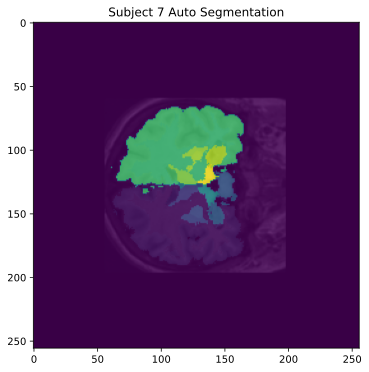

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.698982,0.672296
C. Cortex,0.685315,0.671156


C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


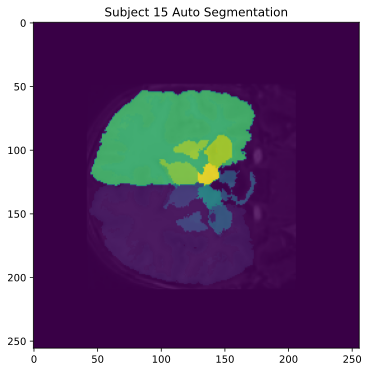

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.770087,0.841866
C. Cortex,0.748338,0.821942


In [190]:
S7, Jac7 = P9(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P9(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

# <b> Method 10: (Warning: Long Run Time)</b>
>Preprocessing applied
<br>
> This method finds a diffeomorphic deformation on the image coordinates that transforms the moving image to the fixed. The diffeomorphic transformation is applied over an image contrast pyramid which is described in the functions above in the transform section. A diffeomorphism is a isomorphism on differentiable manifolds (every point is locally similar to an euclidean space). We also use a sum of absolute squared loss function. The optimization is performed through a demons algorithm based on optical flow. To determine pixel values in our result segmentation, we use a correlational weighted majority voting scheme. Additionally, each training image is denoised and is histogram specified to the input image's histogram. This link helped me learn how to use the library.
<br>
URL: https://simpleitk.readthedocs.io/en/master/link_DemonsRegistration1_docs.html
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- For each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find an optimized diffeomorphism that takes each moving image to the fixed image via an image pyramid
- Perform these optimized transformations one each of the training images
- For all the training segmentations, perform the transformation
- Each pixel intensity in the output segementation is the weighted majority of the same pixels across all the transformed segmentations of the transformed training images with weights based on correlation of that training image with the original image. Correlation is per pixel and based on an 11x11 neighborhood. 11x11 was determined by experimentation. This should theoretically reduce errors.

In [142]:
def P10(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    
    # First find an affine transform for each of the training data to img
    a1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1img[0], isim = isim, Transform = affineTransform)
    a2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2img[0], isim = isim, Transform = affineTransform)
    a3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3img[0], isim = isim, Transform = affineTransform)
    a4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4img[0], isim = isim, Transform = affineTransform)
    a5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5img[0], isim = isim, Transform = affineTransform)
    a6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6img[0], isim = isim, Transform = affineTransform)
    
    # Set all the training data to the affine Transformed training data we found
    S1 = a1p[1]
    S2 = a2p[1]
    S3 = a3p[1]
    S4 = a4p[1]
    S5 = a5p[1]
    S6 = a6p[1]
    
    # Perform the transformations onto all the segmentation images
    seg1 = affineTransform(S1seg[0], a1p[0])
    seg2 = affineTransform(S2seg[0], a2p[0])
    seg3 = affineTransform(S3seg[0], a3p[0])
    seg4 = affineTransform(S4seg[0], a4p[0])
    seg5 = affineTransform(S5seg[0], a5p[0])
    seg6 = affineTransform(S6seg[0], a6p[0])
    
    # Convert all image format the sitk image format
    img = sitk.GetImageFromArray(img/np.max(img), sitk.sitkFloat32)
    img = sitk.VectorIndexSelectionCast(img,0)
    S1 = sitk.GetImageFromArray(S1/np.max(S1), sitk.sitkFloat32)
    S1 = sitk.VectorIndexSelectionCast(S1,0)
    S2 = sitk.GetImageFromArray(S2/np.max(S2), sitk.sitkFloat32)
    S2 = sitk.VectorIndexSelectionCast(S2,0)
    S3 = sitk.GetImageFromArray(S3/np.max(S3), sitk.sitkFloat32)
    S3 = sitk.VectorIndexSelectionCast(S3,0)
    S4 = sitk.GetImageFromArray(S4/np.max(S4), sitk.sitkFloat32)
    S4 = sitk.VectorIndexSelectionCast(S4,0)
    S5 = sitk.GetImageFromArray(S5/np.max(S5), sitk.sitkFloat32)
    S5 = sitk.VectorIndexSelectionCast(S5,0)
    S6 = sitk.GetImageFromArray(S6/np.max(S6), sitk.sitkFloat32)
    S6 = sitk.VectorIndexSelectionCast(S6,0)
    
    # Perform histogram matching to img for all training images
        # We use Simple itk's histogram matching
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(1024) # We use 1024 bins
    matcher.SetNumberOfMatchPoints(7) # 7 quantiles for matching
    matcher.ThresholdAtMeanIntensityOff() # Use mean thresholding to get rid of background
    
    img = matcher.Execute(img, S3)
    S1 = matcher.Execute(S1, S3)
    S2 = matcher.Execute(S2, S3)
    S3 = matcher.Execute(S3, S3)
    S4 = matcher.Execute(S4, S3)
    S5 = matcher.Execute(S5, S3)
    S6 = matcher.Execute(S6, S3)
    
    # Perform diffeomorphic registration using the demons algorithm on a gaussian image pyramid
    reg1p = multiscale_diffeomorphic_contrast(img, S1, interp = sitk.sitkLinear)
    reg2p = multiscale_diffeomorphic_contrast(img, S2, interp = sitk.sitkLinear)
    reg3p = multiscale_diffeomorphic_contrast(img, S3, interp = sitk.sitkLinear)
    reg4p = multiscale_diffeomorphic_contrast(img, S4, interp = sitk.sitkLinear)
    reg5p = multiscale_diffeomorphic_contrast(img, S5, interp = sitk.sitkLinear)
    reg6p = multiscale_diffeomorphic_contrast(img, S6, interp = sitk.sitkLinear)
    
    # Isolating transformed images
    reg1 = sitk.GetArrayFromImage(reg1p[1])
    reg2 = sitk.GetArrayFromImage(reg2p[1])
    reg3 = sitk.GetArrayFromImage(reg3p[1])
    reg4 = sitk.GetArrayFromImage(reg4p[1])
    reg5 = sitk.GetArrayFromImage(reg5p[1])
    reg6 = sitk.GetArrayFromImage(reg6p[1])
    
    # Min max recale the segmentations so it works with simple itk
    maxvals = np.array([np.max(seg1), np.max(seg2), np.max(seg3), 
                        np.max(seg4), np.max(seg5), np.max(seg6)])
    
    # Perform the diffeomorphic transformation on the segmentations
    seg1 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg1/np.max(seg1), sitk.sitkFloat32),0), 
                         reg1p[0], sitk.sitkNearestNeighbor)
    seg1 = sitk.GetArrayFromImage(seg1)
    seg2 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg2/np.max(seg2), sitk.sitkFloat32),0), 
                         reg2p[0], sitk.sitkNearestNeighbor)
    seg2 = sitk.GetArrayFromImage(seg2)
    seg3 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg3/np.max(seg3), sitk.sitkFloat32),0), 
                         reg3p[0], sitk.sitkNearestNeighbor)
    seg3 = sitk.GetArrayFromImage(seg3)
    seg4 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg4/np.max(seg4), sitk.sitkFloat32),0), 
                         reg4p[0], sitk.sitkNearestNeighbor)
    seg4 = sitk.GetArrayFromImage(seg4)
    seg5 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg5/np.max(seg5), sitk.sitkFloat32),0), 
                         reg5p[0], sitk.sitkNearestNeighbor)
    seg5 = sitk.GetArrayFromImage(seg5)
    seg6 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg6/np.max(seg6), sitk.sitkFloat32),0), 
                         reg6p[0], sitk.sitkNearestNeighbor)
    seg6 = sitk.GetArrayFromImage(seg6)
    
    
    # Make an array of all these segmented and transformed training 
        # images so we can pass it to the weighted majority segmentation function
        # Rescale to the proper pixel values
    S = np.array([maxvals[0]*seg1, maxvals[1]*seg2, maxvals[2]*seg3, 
                  maxvals[3]*seg4, maxvals[4]*seg5, maxvals[5]*seg6])
    S = np.ndarray.astype(S, np.int)
    timg = np.array([reg1, reg2, reg3, reg4, reg5, reg6])
    
    # Perform majority segmentation
    result = corSeg(td = S, timg = timg, img = sitk.GetArrayFromImage(img))
    #result = pmajSeg(td = S)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

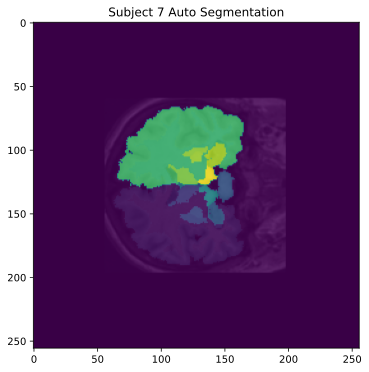

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.709037,0.682473
C. Cortex,0.696068,0.693229


C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


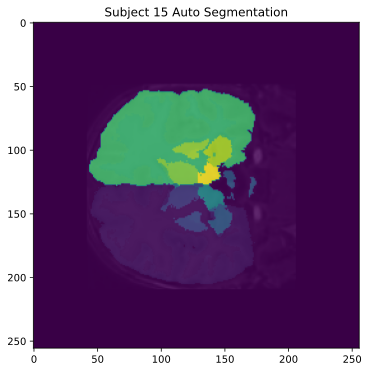

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.833887,0.849968
C. Cortex,0.807889,0.852332


In [143]:
S7, Jac7 = P10(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P10(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

# <b> Method 11: (Warning: Long Run Time)</b>
>Preprocessing applied
<br>
> This method finds a diffeomorphic deformation on the image coordinates that transforms the moving image to the fixed. The diffeomorphic transformation is applied over an image gaussian pyramid which is described in the functions above in the transform section. A diffeomorphism is a isomorphism on differentiable manifolds (every point is locally similar to an euclidean space). We also use a sum of absolute squared loss function. The optimization is performed through a demons algorithm based on optical flow. To determine pixel values in our result segmentation, we use a correlational weighted majority voting scheme. Additionally, each training image is denoised and is histogram specified to the input image's histogram. This link helped me learn how to use the library.
<br>
URL: https://simpleitk.readthedocs.io/en/master/link_DemonsRegistration1_docs.html
<br>
<b>Input:</b> 
<br><ins>img</ins> - Image we want to perform segmentation and registration on
<br><ins>manualSeg</ins> - segmentation of the this image (if we don't know this segmentation we can leave empty)
<br>
<b>Output:</b> Segmentation of the Image. If manualSeg is provided return a tuple of the segmentation and a Dataframe containing Jaccard overlaps for each ROI
<br>
<br>
__Steps:__ <br>
- For each Training image, perform histogram matching to the input fixed image before doing the following steps
- Find an optimized diffeomorphism that takes each moving image to the fixed image via an image pyramid
- Perform these optimized transformations one each of the training images
- For all the training segmentations, perform the transformation
- Each pixel intensity in the output segementation is the weighted majority of the same pixels across all the transformed segmentations of the transformed training images with weights based on correlation of that training image with the original image. Correlation is per pixel and based on an 11x11 neighborhood. 11x11 was determined by experimentation. This should theoretically reduce errors.

In [146]:
def P11(img, manualSeg = None):
    # Initial simplex for Nelder Mead Optimization
    isim = np.array([[1, 0, 0, 0, 1, 0], 
                   [1.1, 0, 0, 0, 1, 0],
                   [1, 0.1, 0, 0, 1, 0],
                   [1, 0, 1, 0, 1, 0],
                   [1, 0, 0, 0.1, 1, 0],
                   [1, 0, 0, 0, 1.1, 0],
                   [1, 0, 0, 0, 1, 1]
                  ])
    
    
    # First find an affine transform for each of the training data to img
    a1p = optimizeNM(lossFunc = SAD, fix = img, mov = S1img[0], isim = isim, Transform = affineTransform)
    a2p = optimizeNM(lossFunc = SAD, fix = img, mov = S2img[0], isim = isim, Transform = affineTransform)
    a3p = optimizeNM(lossFunc = SAD, fix = img, mov = S3img[0], isim = isim, Transform = affineTransform)
    a4p = optimizeNM(lossFunc = SAD, fix = img, mov = S4img[0], isim = isim, Transform = affineTransform)
    a5p = optimizeNM(lossFunc = SAD, fix = img, mov = S5img[0], isim = isim, Transform = affineTransform)
    a6p = optimizeNM(lossFunc = SAD, fix = img, mov = S6img[0], isim = isim, Transform = affineTransform)
    
    # Set all the training data to the affine Transformed training data we found
    S1 = a1p[1]
    S2 = a2p[1]
    S3 = a3p[1]
    S4 = a4p[1]
    S5 = a5p[1]
    S6 = a6p[1]
    
    # Perform the transformations onto all the segmentation images
    seg1 = affineTransform(S1seg[0], a1p[0])
    seg2 = affineTransform(S2seg[0], a2p[0])
    seg3 = affineTransform(S3seg[0], a3p[0])
    seg4 = affineTransform(S4seg[0], a4p[0])
    seg5 = affineTransform(S5seg[0], a5p[0])
    seg6 = affineTransform(S6seg[0], a6p[0])
    
    # Convert all image format the sitk image format
    img = sitk.GetImageFromArray(img/np.max(img), sitk.sitkFloat32)
    img = sitk.VectorIndexSelectionCast(img,0)
    S1 = sitk.GetImageFromArray(S1/np.max(S1), sitk.sitkFloat32)
    S1 = sitk.VectorIndexSelectionCast(S1,0)
    S2 = sitk.GetImageFromArray(S2/np.max(S2), sitk.sitkFloat32)
    S2 = sitk.VectorIndexSelectionCast(S2,0)
    S3 = sitk.GetImageFromArray(S3/np.max(S3), sitk.sitkFloat32)
    S3 = sitk.VectorIndexSelectionCast(S3,0)
    S4 = sitk.GetImageFromArray(S4/np.max(S4), sitk.sitkFloat32)
    S4 = sitk.VectorIndexSelectionCast(S4,0)
    S5 = sitk.GetImageFromArray(S5/np.max(S5), sitk.sitkFloat32)
    S5 = sitk.VectorIndexSelectionCast(S5,0)
    S6 = sitk.GetImageFromArray(S6/np.max(S6), sitk.sitkFloat32)
    S6 = sitk.VectorIndexSelectionCast(S6,0)
    
    # Perform histogram matching to img for all training images
        # We use Simple itk's histogram matching
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(1024) # We use 1024 bins
    matcher.SetNumberOfMatchPoints(7) # 7 quantiles for matching
    matcher.ThresholdAtMeanIntensityOff() # Use mean thresholding to get rid of background
    
    img = matcher.Execute(img, S3)
    S1 = matcher.Execute(S1, S3)
    S2 = matcher.Execute(S2, S3)
    S3 = matcher.Execute(S3, S3)
    S4 = matcher.Execute(S4, S3)
    S5 = matcher.Execute(S5, S3)
    S6 = matcher.Execute(S6, S3)
    
    # Perform diffeomorphic registration using the demons algorithm on a gaussian image pyramid
    reg1p = multiscale_diffeomorphic(img, S1, interp = sitk.sitkLinear)
    reg2p = multiscale_diffeomorphic(img, S2, interp = sitk.sitkLinear)
    reg3p = multiscale_diffeomorphic(img, S3, interp = sitk.sitkLinear)
    reg4p = multiscale_diffeomorphic(img, S4, interp = sitk.sitkLinear)
    reg5p = multiscale_diffeomorphic(img, S5, interp = sitk.sitkLinear)
    reg6p = multiscale_diffeomorphic(img, S6, interp = sitk.sitkLinear)
    
    # Isolating transformed images
    reg1 = sitk.GetArrayFromImage(reg1p[1])
    reg2 = sitk.GetArrayFromImage(reg2p[1])
    reg3 = sitk.GetArrayFromImage(reg3p[1])
    reg4 = sitk.GetArrayFromImage(reg4p[1])
    reg5 = sitk.GetArrayFromImage(reg5p[1])
    reg6 = sitk.GetArrayFromImage(reg6p[1])
    
    # Min max recale the segmentations so it works with simple itk
    maxvals = np.array([np.max(seg1), np.max(seg2), np.max(seg3), 
                        np.max(seg4), np.max(seg5), np.max(seg6)])
    
    # Perform the diffeomorphic transformation on the segmentations
    seg1 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg1/np.max(seg1), sitk.sitkFloat32),0), 
                         reg1p[0], sitk.sitkNearestNeighbor)
    seg1 = sitk.GetArrayFromImage(seg1)
    seg2 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg2/np.max(seg2), sitk.sitkFloat32),0), 
                         reg2p[0], sitk.sitkNearestNeighbor)
    seg2 = sitk.GetArrayFromImage(seg2)
    seg3 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg3/np.max(seg3), sitk.sitkFloat32),0), 
                         reg3p[0], sitk.sitkNearestNeighbor)
    seg3 = sitk.GetArrayFromImage(seg3)
    seg4 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg4/np.max(seg4), sitk.sitkFloat32),0), 
                         reg4p[0], sitk.sitkNearestNeighbor)
    seg4 = sitk.GetArrayFromImage(seg4)
    seg5 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg5/np.max(seg5), sitk.sitkFloat32),0), 
                         reg5p[0], sitk.sitkNearestNeighbor)
    seg5 = sitk.GetArrayFromImage(seg5)
    seg6 = sitk.Resample(sitk.VectorIndexSelectionCast(sitk.GetImageFromArray(seg6/np.max(seg6), sitk.sitkFloat32),0), 
                         reg6p[0], sitk.sitkNearestNeighbor)
    seg6 = sitk.GetArrayFromImage(seg6)
    
    
    # Make an array of all these segmented and transformed training 
        # images so we can pass it to the weighted majority segmentation function
        # Rescale to the proper pixel values
    S = np.array([maxvals[0]*seg1, maxvals[1]*seg2, maxvals[2]*seg3, 
                  maxvals[3]*seg4, maxvals[4]*seg5, maxvals[5]*seg6])
    S = np.ndarray.astype(S, np.int)
    timg = np.array([reg1, reg2, reg3, reg4, reg5, reg6])
    
    # Perform majority segmentation
    result = corSeg(td = S, timg = timg, img = sitk.GetArrayFromImage(img))
    #result = pmajSeg(td = S)
    # If we are not given manual segmentation, return segmentation
    if(manualSeg is None):
        return result
    
    # Else calculate Jaccard Overlap
    JacLCWM = JacOverlap(result, manualSeg, 'Left-Cerebral-White-Matter')
    JacRCWM = JacOverlap(result, manualSeg, 'Right-Cerebral-White-Matter')
    JacLCC = JacOverlap(result, manualSeg, 'Left-Cerebral-Cortex')
    JacRCC = JacOverlap(result, manualSeg, 'Right-Cerebral-Cortex')
    
    Jacs = [[JacLCWM, JacRCWM], [JacLCC, JacRCC]]
    Jacsdf = pd.DataFrame(Jacs, columns = ['Left', 'Right'], index = ['C. White Matter', 'C. Cortex'])
    return (result, Jacsdf)

>Now we put validation subject 7 and 15 through the function

C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


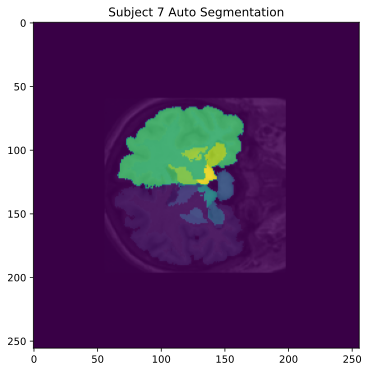

S7 Jaccard Overlaps:


,Left,Right
C. White Matter,0.699502,0.668516
C. Cortex,0.680308,0.669156


C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


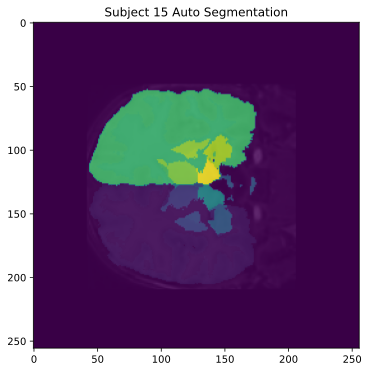

S15 Jaccard Overlaps:


,Left,Right
C. White Matter,0.854571,0.857051
C. Cortex,0.820210,0.870606


In [147]:
S7, Jac7 = P11(S7img[0], S7seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S7)
plt.imshow(S7img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 7 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S7 Jaccard Overlaps:")
display(Jac7)

S15, Jac15 = P11(S15img[0], S15seg[0])

plt.rcParams['figure.figsize'] = (6, 6)

# Here are the segmentations that I ended up with for S7
plt.imshow(S15)
plt.imshow(S15img[0], alpha = 0.4, cmap = 'gray')
plt.title("Subject 15 Auto Segmentation")
plt.show()

# Jaccard Overlaps:
print("S15 Jaccard Overlaps:")
display(Jac15)

__Import Data on the Test Subjects:__

In [150]:
#load the data from milestone 1
TestData = np.load('TestingData.npy', allow_pickle=True)

'''
    - The images are min maxed normalized between 0 and 255
'''

#Testing Data

S8 = np.ndarray.astype(np.array([TestData[0]/np.max(TestData[0])*255]), np.int)
S9 = np.ndarray.astype(np.array([TestData[1]/np.max(TestData[1])*255]), np.int)
S10 = np.ndarray.astype(np.array([TestData[2]/np.max(TestData[2])*255]), np.int)
S11 = np.ndarray.astype(np.array([TestData[3]/np.max(TestData[3])*255]), np.int)
S12 = np.ndarray.astype(np.array([TestData[4]/np.max(TestData[4])*255]), np.int)
S13 = np.ndarray.astype(np.array([TestData[5]/np.max(TestData[5])*255]), np.int)
S14 = np.ndarray.astype(np.array([TestData[6]/np.max(TestData[6])*255]), np.int)
S16 = np.ndarray.astype(np.array([TestData[7]/np.max(TestData[7])*255]), np.int)
S17 = np.ndarray.astype(np.array([TestData[8]/np.max(TestData[8])*255]), np.int)

__Testing the Segmentation Algorithms on the Test Subjects:__

In [181]:
''' performs encoding on segmentations to correct format for kaggle. Code provided on kaggle website'''
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [191]:
seg8 = P10(S8[0])
seg9 = P10(S9[0])
seg10 = P10(S10[0])
seg11 = P10(S11[0])
seg12 = P10(S12[0])
seg13 = P10(S13[0])
seg14 = P10(S14[0])
seg16 = P10(S16[0])
seg17 = P10(S17[0])

C:\Users\Hamilton Lee\.conda\envs\ECE4250\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


__Visualizing the Segmentations__

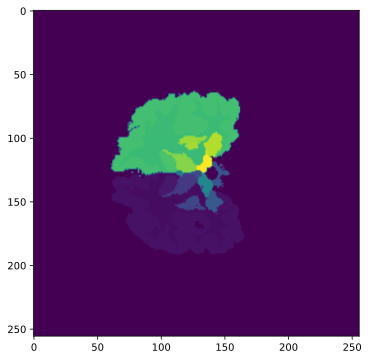

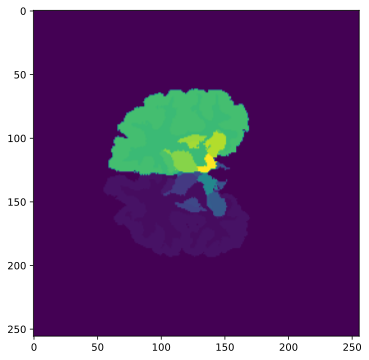

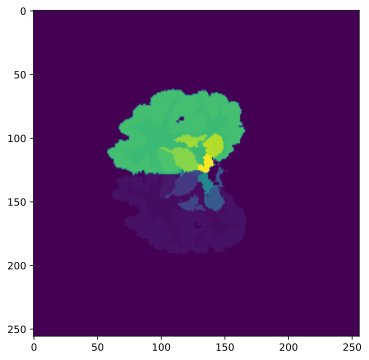

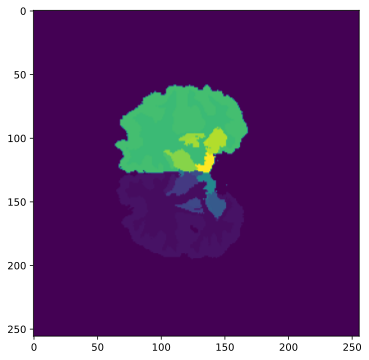

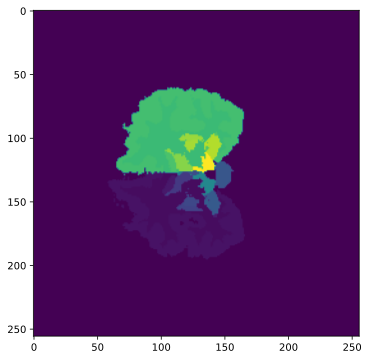

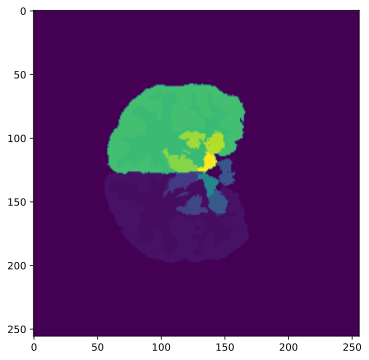

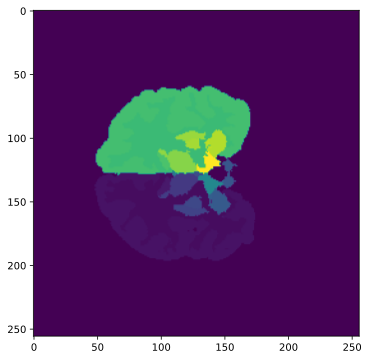

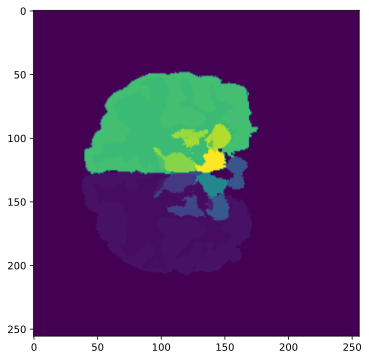

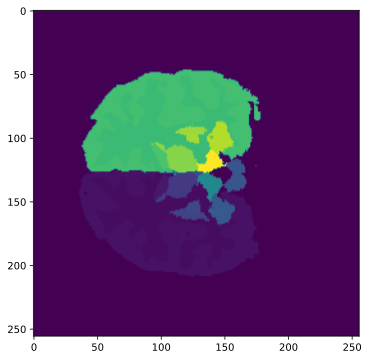

In [192]:
seg8 = np.ndarray.astype(seg8, np.int)
plt.imshow(seg8)
plt.show()
seg9 = np.ndarray.astype(seg9, np.int)
plt.imshow(seg9)
plt.show()
seg10 = np.ndarray.astype(seg10, np.int)
plt.imshow(seg10)
plt.show()
seg11 = np.ndarray.astype(seg11, np.int)
plt.imshow(seg11)
plt.show()
seg12 = np.ndarray.astype(seg12, np.int)
plt.imshow(seg12)
plt.show()
seg13 = np.ndarray.astype(seg13, np.int)
plt.imshow(seg13)
plt.show()
seg14 = np.ndarray.astype(seg14, np.int)
plt.imshow(seg14)
plt.show()
seg16 = np.ndarray.astype(seg16, np.int)
plt.imshow(seg16)
plt.show()
seg17 = np.ndarray.astype(seg17, np.int)
plt.imshow(seg17)
plt.show()

In [184]:
'''Encoding all segmentations'''
s8lwm = rle_encode(seg8==ROIs['Left-Cerebral-White-Matter'])
s8rwm = rle_encode(seg8==ROIs['Right-Cerebral-White-Matter'])
s8lc = rle_encode(seg8==ROIs['Left-Cerebral-Cortex'])
s8rc = rle_encode(seg8==ROIs['Right-Cerebral-Cortex'])

s9lwm = rle_encode(seg9==ROIs['Left-Cerebral-White-Matter'])
s9rwm = rle_encode(seg9==ROIs['Right-Cerebral-White-Matter'])
s9lc = rle_encode(seg9==ROIs['Left-Cerebral-Cortex'])
s9rc = rle_encode(seg9==ROIs['Right-Cerebral-Cortex'])

s10lwm = rle_encode(seg10==ROIs['Left-Cerebral-White-Matter'])
s10rwm = rle_encode(seg10==ROIs['Right-Cerebral-White-Matter'])
s10lc = rle_encode(seg10==ROIs['Left-Cerebral-Cortex'])
s10rc = rle_encode(seg10==ROIs['Right-Cerebral-Cortex'])

s11lwm = rle_encode(seg11==ROIs['Left-Cerebral-White-Matter'])
s11rwm = rle_encode(seg11==ROIs['Right-Cerebral-White-Matter'])
s11lc = rle_encode(seg11==ROIs['Left-Cerebral-Cortex'])
s11rc = rle_encode(seg11==ROIs['Right-Cerebral-Cortex'])

s12lwm = rle_encode(seg12==ROIs['Left-Cerebral-White-Matter'])
s12rwm = rle_encode(seg12==ROIs['Right-Cerebral-White-Matter'])
s12lc = rle_encode(seg12==ROIs['Left-Cerebral-Cortex'])
s12rc = rle_encode(seg12==ROIs['Right-Cerebral-Cortex'])

s13lwm = rle_encode(seg13==ROIs['Left-Cerebral-White-Matter'])
s13rwm = rle_encode(seg13==ROIs['Right-Cerebral-White-Matter'])
s13lc = rle_encode(seg13==ROIs['Left-Cerebral-Cortex'])
s13rc = rle_encode(seg13==ROIs['Right-Cerebral-Cortex'])

s14lwm = rle_encode(seg14==ROIs['Left-Cerebral-White-Matter'])
s14rwm = rle_encode(seg14==ROIs['Right-Cerebral-White-Matter'])
s14lc = rle_encode(seg14==ROIs['Left-Cerebral-Cortex'])
s14rc = rle_encode(seg14==ROIs['Right-Cerebral-Cortex'])

s16lwm = rle_encode(seg16==ROIs['Left-Cerebral-White-Matter'])
s16rwm = rle_encode(seg16==ROIs['Right-Cerebral-White-Matter'])
s16lc = rle_encode(seg16==ROIs['Left-Cerebral-Cortex'])
s16rc = rle_encode(seg16==ROIs['Right-Cerebral-Cortex'])

s17lwm = rle_encode(seg17==ROIs['Left-Cerebral-White-Matter'])
s17rwm = rle_encode(seg17==ROIs['Right-Cerebral-White-Matter'])
s17lc = rle_encode(seg17==ROIs['Left-Cerebral-Cortex'])
s17rc = rle_encode(seg17==ROIs['Right-Cerebral-Cortex'])

In [185]:
labels = ['8-left-wm', '8-left-cortex', '8-right-wm', '8-right-cortex',
          '9-left-wm', '9-left-cortex', '9-right-wm', '9-right-cortex',
          '10-left-wm', '10-left-cortex', '10-right-wm', '10-right-cortex',
          '11-left-wm', '11-left-cortex', '11-right-wm', '11-right-cortex',
          '12-left-wm', '12-left-cortex', '12-right-wm', '12-right-cortex',
          '13-left-wm', '13-left-cortex', '13-right-wm', '13-right-cortex',
          '14-left-wm', '14-left-cortex', '14-right-wm', '14-right-cortex',
          '16-left-wm', '16-left-cortex', '16-right-wm', '16-right-cortex',
          '17-left-wm', '17-left-cortex', '17-right-wm', '17-right-cortex'
         ]
data = [s8lwm, s8lc, s8rwm, s8rc,
        s9lwm, s9lc, s9rwm, s9rc,
        s10lwm, s10lc, s10rwm, s10rc,
        s11lwm, s11lc, s11rwm, s11rc,
        s12lwm, s12lc, s12rwm, s12rc,
        s13lwm, s13lc, s13rwm, s13rc,
        s14lwm, s14lc, s14rwm, s14rc,
        s16lwm, s16lc, s16rwm, s16rc,
        s17lwm, s17lc, s17rwm, s17rc,
       ]
### ids: list containing the 36 IDs as described above  ###
### data: list containing the 36 binary segmentation masks in RLE format ###
df = pd.DataFrame({"Id": labels, "Predicted": data})
df.to_csv('submission2.csv', index = False)